In [1]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pygeos
import geopandas as gpd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import interpolate
import seaborn as sns
import pyproj
import pygeos
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from rasterstats import zonal_stats

# path to python scripts
sys.path.append(os.path.join('..','src','trails'))

from population_OD import *

from network import *

In [2]:
def get_area_km2(geometries):
    """This method adds a distance column using pygeos (converted from shapely) 
    assuming the new crs from the latitude and longitude of the first node
    distance is in metres

    Args:
        network (class): A network composed of nodes (points in space) and edges (lines)

    Returns:
        network (class): A network composed of nodes (points in space) and edges (lines)
    """    

    #Find crs of current df and arbitrary point(lat,lon) for new crs
    current_crs="epsg:4326"
    #The commented out crs does not work in all cases
    #current_crs = [*network.edges.crs.values()]
    #current_crs = str(current_crs[0])
    lat = pygeos.get_y(pygeos.centroid(geometry))
    lon = pygeos.get_x(pygeos.centroid(geometry))
    # formula below based on :https://gis.stackexchange.com/a/190209/80697 
    approximate_crs = "epsg:" + str(int(32700-np.round((45+lat)/90,0)*100+np.round((183+lon)/6,0)))
    #from pygeos/issues/95
    coords = pygeos.get_coordinates(geometry)
    transformer=pyproj.Transformer.from_crs(current_crs, approximate_crs,always_xy=True)
    new_coords = transformer.transform(coords[:, 0], coords[:, 1])
    result = pygeos.set_coordinates(geometry, np.array(new_coords).T)
    return pygeos.area(result)

def get_average_slope(geometry):
    slope_path = 'C:\Data\Global_Geospatial\geo\dtm_slope_merit.dem_m_1km_s0..0cm_2017_v1.0.tif'
    out = zonal_stats(geometry,slope_path)[0]
    return out['mean'],out['max']

def get_total_population(geometry):
    geo_path = 'C:\Data\Global_Geospatial\worldpop\ppp_2018_1km_Aggregated.tif'
    out = zonal_stats(geometry,geo_path,stats='sum')[0]
    return out['sum']

def get_builtup_area(geometry):
    geo_path = 'C:\Data\Global_Geospatial//builtuparea\GHS_builtup_wgs84.tif'
    out = zonal_stats(geometry,geo_path)[0]
    return out['mean']

def add_landlocked(country_code):
    
    landlocked = ['AFG','AND','ARM','AUT','AZE','BLR','BTN','BOL','BFA','BDI','CAF','TCD','CZE',
    'SWZ','ETH','HUN','KAZ','KGZ','LAO','LSO','LTE','LUX','MWI','MLI','MDA','MNG',
    'NPL','NER','MKD','PRY','RWA','SRB','SVK','SSD','CHE','TJK','TKM','UGA','UZB','ZMB','ZWE']

    if country_code in landlocked:
        return 1
    else:
        return 0
    
def connect_area(area_dict,x):
    try:
        return area_dict[x]
    except:
        return 0    

In [3]:
# set data paths to results
data_random_attack = r'C:\Data\Global_Percolation\percolation_results_random_attack_regular'
data_targeted_attack = r'C:\Data\Global_Percolation\percolation_results_targeted_attack'
data_local_attack_05 = r'C:\Data\Global_Percolation\percolation_results_local_attack_05'
data_local_attack_01 = r'C:\Data\Global_Percolation\percolation_results_local_attack_01'
data_local_attack_005 = r'C:\Data\Global_Percolation\percolation_results_local_attack_005'

data_path_met= r'C:\Data\Global_Percolation\percolation_metrics'
data_path_net = r'C:\Data\Global_Percolation\percolation_networks'
data_path_grids = r'C:\Data\Global_Percolation\percolation_grids'

# file to get full country names
glob_info = pd.read_excel(r'C:\Projects\trails\data\global_information.xlsx')
gdp_cap_country = pd.read_csv(r'C:\trails\data\percolation\worldbank_gdp_2019.csv',sep=';')
income_groups = pd.read_excel(r'C:\trails\data\percolation\CLASS.xls',sheet_name='Groups')

# get all files from data paths
perc_files_random_attack = os.listdir(data_random_attack)
perc_files_targeted_attack = os.listdir(data_targeted_attack)
perc_files_local_attack_05 = os.listdir(data_local_attack_05)
perc_files_local_attack_01 = os.listdir(data_local_attack_01)
perc_files_local_attack_005 = os.listdir(data_local_attack_005)

grid_files = os.listdir(data_path_grids)

met_files = os.listdir(data_path_met)
net_files = os.listdir(data_path_net)

In [4]:
income_groups = income_groups.loc[(income_groups.GroupName.str.contains('High income')) | (
     income_groups.GroupName.str.contains('Upper middle income')) | (
     income_groups.GroupName.str.contains('Lower middle income')) | (
     income_groups.GroupName.str.contains('Low income'))].reset_index(drop=True)

In [5]:
gadm36 = gpd.read_file(r'C:/Data/Global_Geospatial/GADM/gadm36_levels.gpkg',layer=0)
py_geoms = pygeos.from_shapely(gadm36.geometry.values)
gadm36.geometry = py_geoms

In [6]:
tqdm.pandas()
slopes = gadm36.geometry.progress_apply(lambda x: get_average_slope(x))
gadm36[['mean_slope', 'max_slope']] = pd.DataFrame(slopes.tolist(), index=slopes.index)

gadm36['builtarea'] = gadm36.geometry.progress_apply(lambda x: get_builtup_area(x))

population = gadm36.geometry.progress_apply(lambda x: get_total_population(x))
gadm36[['tot_pop']] = pd.DataFrame(population.tolist(), index=population.index)

gadm36['landlocked'] = gadm36.GID_0.progress_apply(lambda x: add_landlocked(x))

collect_area = []
for geometry in tqdm(py_geoms,total=len(py_geoms)):
    collect_area.append(get_area_km2(geometry)/1e6) 
gadm36['area'] = collect_area

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:15<00:00, 16.11it/s]


In [7]:
area_dict = dict(zip(gadm36['GID_0'],gadm36['area']))
continent_dict = dict(zip(glob_info['ISO_3digit'],glob_info['continent']))
sids_dict = dict(zip(glob_info['ISO_3digit'],glob_info['SIDS']))
gdp_cap_dict = dict(zip(gdp_cap_country['iso'],gdp_cap_country['gdp']))
income_dict = dict(zip(income_groups['CountryCode'],income_groups['GroupName']))
mean_slope_dict = dict(zip(gadm36['GID_0'],gadm36['mean_slope']))
max_slope_dict = dict(zip(gadm36['GID_0'],gadm36['max_slope']))
landlocked_dict = dict(zip(gadm36['GID_0'],gadm36['landlocked']))
population_dict = dict(zip(gadm36['GID_0'],gadm36['tot_pop']))
builtup_dict = dict(zip(gadm36['GID_0'],gadm36['builtarea']))

In [8]:
glob_info['area'] = glob_info.ISO_3digit.apply(lambda x: connect_area(area_dict,x)) 

In [9]:
%%time
urban_areas = gpd.read_file(r'C:\Data\Global_Geospatial\GHS_STAT_UCDB2015MT_GLOBE_R2019A\GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
urban_areas = pd.DataFrame(urban_areas.copy())
urban_areas.geometry = pygeos.make_valid(pygeos.from_shapely(urban_areas.geometry))
tree = pygeos.STRtree(urban_areas.geometry.values)

Wall time: 4.32 s


In [10]:
# connect facts to grids
for country in (glob_info.ISO_3digit.values):
    network = 0
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
     
    except:
         print('{} has no 05 grid!'.format(country))
            
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
     
    except:
         print('{} has no 01 grid!'.format(country))
            
    try:
        ctry_grid = pd.read_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
        if 'urban' in ctry_grid.columns:
             #print('{} already done!'.format(country))
            continue 
        tqdm.pandas(desc=country)
        ctry_grid.geometry = pygeos.from_wkt(ctry_grid.geometry)
        urban_geoms = urban_areas.iloc[tree.query_bulk(ctry_grid.geometry.values,predicate='intersects').tolist()[1]]['geometry'].values    
        ctry_grid['urban'] = False
        ctry_grid['urban'] = ctry_grid.geometry.progress_apply(lambda x : any(pygeos.intersects(x,urban_geoms)))
        ctry_grid.to_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
     
    except:
         print('{} has no 005 grid!'.format(country))            

CCK has no 05 grid!
CCK has no 01 grid!
CCK has no 005 grid!
SJM has no 05 grid!
SJM has no 01 grid!
SJM has no 005 grid!
SPM has no 05 grid!
SPM has no 01 grid!
SPM has no 005 grid!
UMI has no 05 grid!
UMI has no 01 grid!
UMI has no 005 grid!
PCN has no 05 grid!
PCN has no 01 grid!
PCN has no 005 grid!
SGS has no 05 grid!
SGS has no 01 grid!
SGS has no 005 grid!
ANT has no 05 grid!
ANT has no 01 grid!
ANT has no 005 grid!
TKL has no 05 grid!
TKL has no 01 grid!
TKL has no 005 grid!
TUV has no 05 grid!
TUV has no 01 grid!
TUV has no 005 grid!


In [11]:
country_metrics = {}

for country in tqdm(glob_info.ISO_3digit.values,total=len(glob_info.ISO_3digit.values)):
    network = 0
    #specify file
    
    collect_metrics = {}

    file = '{}_{}_results.csv'.format(country,network)
    
    try:
        # load metrics
        df_metrics = pd.read_csv(os.path.join(data_path_met,[x for x in met_files if file[:5] in x][0]))

        collect_metrics['general'] = (df_metrics.Density.values[0],df_metrics.Clique_No.values[0],df_metrics.Edge_Connectivity.values[0],
                                     df_metrics.Ave_Path_Length.values[0],df_metrics.Assortativity.values[0],
                                     df_metrics.Diameter.values[0],df_metrics.Max_Degree.values[0],df_metrics.Transivitity.values[0],
                                     df_metrics.Articulation_Points.values[0],df_metrics.Total_Edge_Length.values[0])
    except:
        continue
        
    # 0.5 degree
    try:
        df_local_05 = pd.read_csv(os.path.join(data_local_attack_05,file),index_col=[0])
        grid_05 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
        grid_05 = grid_05.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_05.grid_no.loc[grid_05.urban == True].values
        
        df_local_05_urban = df_local_05.loc[df_local_05.grid_no.isin(urban_grids)]
        df_local_05_rural = df_local_05.loc[~df_local_05.grid_no.isin(urban_grids)]

        isolated_05 = df_local_05.loc[df_local_05.pct_isolated != 0].reset_index(drop=True)           
        delayed_05 = df_local_05.loc[df_local_05.pct_delayed != 0].reset_index(drop=True)

        isolated_05_urban = df_local_05_urban.loc[df_local_05_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_05_urban = df_local_05_urban.loc[df_local_05_urban.pct_delayed != 0].reset_index(drop=True)
        
        isolated_05_rural = df_local_05_rural.loc[df_local_05_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_05_rural = df_local_05_rural.loc[df_local_05_rural.pct_delayed != 0].reset_index(drop=True)
        
        if len(df_local_05) > 0:
            perc_isolated_trips = round(len(isolated_05)/len(df_local_05)*100,2)
            perc_delayed_trips = round(len(delayed_05)/len(df_local_05)*100,2)

            if len(isolated_05) > 0:
                avg_isolated = round(isolated_05.pct_isolated.mean(),2)   
                max_isolated = round(isolated_05.pct_isolated.max(),2)   
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_05) > 0:
                avg_delayed = round(delayed_05.pct_delayed.mean(),2)
                max_delayed = round(delayed_05.pct_delayed.mean(),2)   
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0

        if len(df_local_05_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_05_urban)/len(df_local_05_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_05_urban)/len(df_local_05_urban)*100,2)

            if len(isolated_05_urban) > 0:
                avg_isolated_urban = round(isolated_05_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_05_urban.pct_isolated.max(),2)   
                
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_05_urban) > 0:
                avg_delayed_urban = round(delayed_05_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_05_urban.pct_delayed.max(),2)
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0
            max_delayed_urban = 0
            
        if len(df_local_05_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_05_rural)/len(df_local_05_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_05_rural)/len(df_local_05_rural)*100,2)

            if len(isolated_05_rural) > 0:
                avg_isolated_rural = round(isolated_05_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_05_rural.pct_isolated.max(),2)   
                
            else:
                avg_isolated_rural = 0
                max_isolated_rural = 0

            if len(delayed_05_rural) > 0:
                avg_delayed_rural = round(delayed_05_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_05_rural.pct_delayed.max(),2)   
                
            else:
                avg_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_05'] = (len(grid_05),len(df_local_05),len(df_local_05_urban),len(df_local_05_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
                                         
    except:
        None
    
    # 0.1 degree
    try:
        df_local_01 = pd.read_csv(os.path.join(data_local_attack_01,file),index_col=[0])
        grid_01 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_01.csv'.format(country,network)))
        grid_01 = grid_01.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_01.grid_no.loc[grid_01.urban == True].values

        df_local_01_urban = df_local_01.loc[df_local_01.grid_no.isin(urban_grids)]
        df_local_01_rural = df_local_01.loc[~df_local_01.grid_no.isin(urban_grids)]

        isolated_01 = df_local_01.loc[df_local_01.pct_isolated != 0].reset_index(drop=True)           
        delayed_01 = df_local_01.loc[df_local_01.pct_delayed != 0].reset_index(drop=True)

        isolated_01_urban = df_local_01_urban.loc[df_local_01_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_01_urban = df_local_01_urban.loc[df_local_01_urban.pct_delayed != 0].reset_index(drop=True)

        isolated_01_rural = df_local_01_rural.loc[df_local_01_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_01_rural = df_local_01_rural.loc[df_local_01_rural.pct_delayed != 0].reset_index(drop=True)

        if len(df_local_01) > 0:
            perc_isolated_trips = round(len(isolated_01)/len(df_local_01)*100,2)
            perc_delayed_trips = round(len(delayed_01)/len(df_local_01)*100,2)

            if len(isolated_01) > 0:
                avg_isolated = round(isolated_01.pct_isolated.mean(),2) 
                max_isolated = round(isolated_01.pct_isolated.max(),2) 
            else:
                avg_isolated = 0
                max_isolated = 0


            if len(delayed_01) > 0:
                avg_delayed = round(delayed_01.pct_delayed.mean(),2)
                max_delayed = round(delayed_01.pct_delayed.max(),2) 
                
            else:
                avg_delayed = 0
                max_delayed = 0
                
        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0
            
        if len(df_local_01_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_01_urban)/len(df_local_01_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_01_urban)/len(df_local_01_urban)*100,2)

            if len(isolated_01_urban) > 0:
                avg_isolated_urban = round(isolated_01_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_01_urban.pct_isolated.max(),2)   
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_01_urban) > 0:
                avg_delayed_urban = round(delayed_01_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_01_urban.pct_delayed.max(),2)   
                
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0            
            max_delayed_urban = 0

        if len(df_local_01_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_01_rural)/len(df_local_01_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_01_rural)/len(df_local_01_rural)*100,2)

            if len(isolated_01_rural) > 0:
                avg_isolated_rural = round(isolated_01_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_01_rural.pct_isolated.max(),2)   
            else:
                avg_isolated_rural = 0

            if len(delayed_01_rural) > 0:
                avg_delayed_rural = round(delayed_01_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_01_rural.pct_delayed.max(),2)   
                
            else:
                avg_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_01'] = (len(grid_01),len(df_local_01),len(df_local_01_urban),len(df_local_01_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
    except:
        None        
        
    # 0.05 degree
    try:
        df_local_005 = pd.read_csv(os.path.join(data_local_attack_005,file),index_col=[0])
        grid_005 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_005.csv'.format(country,network)))
        grid_005 = grid_005.rename(columns={"Unnamed: 0": "grid_no"})
        urban_grids = grid_005.grid_no.loc[grid_005.urban == True].values
        
        df_local_005_urban = df_local_005.loc[df_local_005.grid_no.isin(urban_grids)]
        df_local_005_rural = df_local_005.loc[~df_local_005.grid_no.isin(urban_grids)]

        isolated_005 = df_local_005.loc[df_local_005.pct_isolated != 0].reset_index(drop=True)           
        delayed_005 = df_local_005.loc[df_local_005.pct_delayed != 0].reset_index(drop=True)

        isolated_005_urban = df_local_005_urban.loc[df_local_005_urban.pct_isolated != 0].reset_index(drop=True)           
        delayed_005_urban = df_local_005_urban.loc[df_local_005_urban.pct_delayed != 0].reset_index(drop=True)
        
        isolated_005_rural = df_local_005_rural.loc[df_local_005_rural.pct_isolated != 0].reset_index(drop=True)           
        delayed_005_rural = df_local_005_rural.loc[df_local_005_rural.pct_delayed != 0].reset_index(drop=True)
        
        if len(df_local_005) > 0:
            perc_isolated_trips = round(len(isolated_005)/len(df_local_005)*100,2)
            perc_delayed_trips = round(len(delayed_005)/len(df_local_005)*100,2)

            if len(isolated_005) > 0:
                avg_isolated = round(isolated_005.pct_isolated.mean(),2)  
                max_isolated = round(isolated_005.pct_isolated.max(),2)   
                
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_005) > 0:
                avg_delayed = round(delayed_005.pct_delayed.mean(),2)
                max_delayed = round(delayed_005.pct_delayed.max(),2)   
                
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0            
            max_delayed = 0
            
        if len(df_local_005_urban) > 0:
            perc_isolated_trips_urban = round(len(isolated_005_urban)/len(df_local_005_urban)*100,2)
            perc_delayed_trips_urban = round(len(delayed_005_urban)/len(df_local_005_urban)*100,2)

            if len(isolated_005_urban) > 0:
                avg_isolated_urban = round(isolated_005_urban.pct_isolated.mean(),2)   
                max_isolated_urban = round(isolated_005_urban.pct_isolated.max(),2)   
                
            else:
                avg_isolated_urban = 0
                max_isolated_urban = 0

            if len(delayed_005_urban) > 0:
                avg_delayed_urban = round(delayed_005_urban.pct_delayed.mean(),2)
                max_delayed_urban = round(delayed_005_urban.pct_delayed.max(),2)
                
            else:
                avg_delayed_urban = 0
                max_delayed_urban = 0

        else:
            perc_isolated_trips_urban = 0
            perc_delayed_trips_urban = 0
            avg_isolated_urban = 0
            avg_delayed_urban = 0 
            max_isolated_urban = 0
            max_delayed_urban = 0 
             
            
        if len(df_local_005_rural) > 0:
            perc_isolated_trips_rural = round(len(isolated_005_rural)/len(df_local_005_rural)*100,2)
            perc_delayed_trips_rural = round(len(delayed_005_rural)/len(df_local_005_rural)*100,2)

            if len(isolated_005_rural) > 0:
                avg_isolated_rural = round(isolated_005_rural.pct_isolated.mean(),2)   
                max_isolated_rural = round(isolated_005_rural.pct_isolated.max(),2)   
                
            else:
                avg_isolated_rural = 0
                max_isolated_rural = 0

            if len(delayed_005_rural) > 0:
                avg_delayed_rural = round(delayed_005_rural.pct_delayed.mean(),2)
                max_delayed_rural = round(delayed_005_rural.pct_delayed.max(),2)
                
            else:
                avg_delayed_rural = 0
                max_delayed_rural = 0

        else:
            perc_isolated_trips_rural = 0
            perc_delayed_trips_rural = 0
            avg_isolated_rural = 0
            avg_delayed_rural = 0 
            max_isolated_rural = 0            
            max_delayed_rural = 0
            
        collect_metrics['local_005'] = (len(grid_005),len(df_local_005),len(df_local_005_urban),len(df_local_005_rural),
                                       perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed,
                                       perc_isolated_trips_urban,avg_isolated_urban,max_isolated_urban,perc_delayed_trips_urban,avg_delayed_urban,max_delayed_urban,
                                       perc_isolated_trips_rural,avg_isolated_rural,max_isolated_rural,perc_delayed_trips_rural,avg_delayed_rural,max_delayed_rural)
        
    except:
        None
        
    # target attack
    try:
        df_target = pd.read_csv(os.path.join(data_targeted_attack,file),index_col=[0])
        isolated_target = df_target.loc[df_target.pct_isolated != 0].reset_index(drop=True)
        delayed_target = df_target.loc[df_target.pct_delayed != 0].reset_index(drop=True)
        if len(df_target) > 0:
            perc_isolated_trips = round(len(isolated_target)/len(df_target)*100,2)
            perc_delayed_trips = round(len(delayed_target)/len(df_target)*100,2)

            if len(isolated_target) > 0:
                avg_isolated = round(isolated_target.pct_isolated.mean(),2)   
                max_isolated = round(isolated_target.pct_isolated.max(),2)   
            else:
                avg_isolated = 0
                max_isolated = 0

            if len(delayed_target) > 0:
                avg_delayed = round(delayed_target.pct_delayed.mean(),2)
                max_delayed = round(delayed_target.pct_delayed.max(),2)   
                
            else:
                avg_delayed = 0
                max_delayed = 0

        else:
            perc_isolated_trips = 0
            perc_delayed_trips = 0
            avg_isolated = 0
            avg_delayed = 0 
            max_isolated = 0
            max_delayed = 0
            
        collect_metrics['target'] = len(df_target),perc_isolated_trips,avg_isolated,max_isolated,perc_delayed_trips,avg_delayed,max_delayed
    except:
        None
        
        # random attack
    try:
        df_random = pd.read_csv(os.path.join(data_random_attack,file),index_col=[0])
        df_random.frac_counter = df_random.frac_counter*100

        df_mean_random = df_random.groupby('frac_counter').mean()
        df_max_random = df_random.groupby('frac_counter').quantile(q=0.95)#.max()
        df_min_random = df_random.groupby('frac_counter').quantile(q=0.05)#.min()

        max_isolated = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_isolated = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_isolated = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.pct_isolated.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_delayed = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_delayed = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_delayed = [round(interpolate.interp1d(df_max_random.index.values,df_min_random.pct_delayed.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_unaffected = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_unaffected = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_unaffected = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.pct_unaffected.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_sloss_e1 = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_sloss_e1 = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_sloss_e1 = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.total_pct_surplus_loss_e1.values,bounds_error=False)(perc).item(),2) for perc in range(101)]

        max_sloss_e2 = [round(interpolate.interp1d(df_max_random.index.values,df_max_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        mean_sloss_e2 = [round(interpolate.interp1d(df_mean_random.index.values,df_mean_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
        min_sloss_e2 = [round(interpolate.interp1d(df_min_random.index.values,df_min_random.total_pct_surplus_loss_e2.values,bounds_error=False)(perc).item(),2) for perc in range(101)]
     
        collect_metrics['random'] = max_isolated,mean_isolated,min_isolated,max_delayed,mean_delayed,min_delayed,max_unaffected,mean_unaffected,min_unaffected,max_sloss_e1,mean_sloss_e1,min_sloss_e1,max_sloss_e2,mean_sloss_e2,min_sloss_e2,

    except:
        None
    
    country_metrics[country] = collect_metrics 
    

100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [01:31<00:00,  2.59it/s]


In [13]:
def add_country_data(country):
    try:
        return country,income_dict[country],gdp_cap_dict[country],area_dict[country],continent_dict[country],sids_dict[country],mean_slope_dict[country],max_slope_dict[country],landlocked_dict[country],population_dict[country],builtup_dict[country]
    except:
        return country,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

collect_random = {}
collect_target = {}
collect_local05 = {}
collect_local01 = {}
collect_local005 = {}
collect_random_od_buffer = {}
collect_general = {}

for country in tqdm(glob_info.ISO_3digit.values,total=len(glob_info.ISO_3digit.values)):
    try:
        collect_general[country] = country_metrics[country]['general']
    except:
        None
    try:
        collect_random[country] = country_metrics[country]['random']
        collect_random_od_buffer[country] = country_metrics[country]['random_od_buffer']      
    except:
        None
    try:
        collect_target[country] = country_metrics[country]['target']   
    except:
        None
        
    try:
        collect_local05[country] = country_metrics[country]['local_05']        
    except:
        None
        
    try:
        collect_local01[country] = country_metrics[country]['local_01']        
    except:
        None
        
    try:
        collect_local005[country] = country_metrics[country]['local_005']        
    except:
        None        

100%|████████████████████████████████████████████████████████████████████████████| 237/237 [00:00<00:00, 237356.74it/s]


In [14]:
df_general = pd.DataFrame(collect_general).T
df_general.columns = ['Density', 'Clique_No','Edge_Connectivity','Ave_Path_Length', 'Assortativity', 'Diameter','Max_Degree',"Transivitity","Articulation_Points",'Total_Edge_Length']

In [15]:
random_results = pd.DataFrame(collect_random).T
random_results.columns = ['max_isolated','mean_isolated','min_isolated','max_delayed','mean_delayed','min_delayed',
                          'max_unaffected','mean_unaffected','min_unaffected','max_sloss_e1','mean_sloss_e1','min_sloss_e1','max_sloss_e2','mean_sloss_e2','min_sloss_e2',]

country_info = pd.DataFrame(random_results.reset_index()['index'].apply(lambda x : add_country_data(x)).tolist())
country_info.dropna(axis=0)
country_info.columns = ['ISO3','IncomeLevel','GDP_CAP','AreaKM','Continent','SIDS','mean_slope','max_slope','landlocked','population','builtarea']

random_min_isolated = pd.DataFrame(random_results.min_isolated.tolist(), index= random_results.index)
random_min_isolated = random_min_isolated.fillna(100)
random_min_isolated = random_min_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_isolated = pd.DataFrame(random_results.mean_isolated.tolist(), index= random_results.index)
random_mean_isolated = random_mean_isolated.fillna(100)
random_mean_isolated = random_mean_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_isolated = pd.DataFrame(random_results.max_isolated.tolist(), index= random_results.index)
random_max_isolated = random_max_isolated.fillna(100)
random_max_isolated = random_max_isolated.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)


In [16]:
random_min_delayed = pd.DataFrame(random_results.min_delayed.tolist(), index= random_results.index)
random_min_delayed = random_min_delayed.fillna(100)
random_min_delayed = random_min_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_delayed = pd.DataFrame(random_results.mean_delayed.tolist(), index= random_results.index)
random_mean_delayed = random_mean_delayed.fillna(100)
random_mean_delayed = random_mean_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_delayed = pd.DataFrame(random_results.max_delayed.tolist(), index= random_results.index)
random_max_delayed = random_max_delayed.fillna(100)
random_max_delayed = random_max_delayed.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

In [17]:
random_min_sloss = pd.DataFrame(random_results.min_sloss_e2.tolist(), index= random_results.index)
random_min_sloss = random_min_sloss.fillna(100)
random_min_sloss = random_min_sloss.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_mean_sloss = pd.DataFrame(random_results.mean_sloss_e2.tolist(), index= random_results.index)
random_mean_sloss = random_mean_sloss.fillna(100)
random_mean_sloss = random_mean_sloss.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

random_max_sloss = pd.DataFrame(random_results.max_sloss_e2.tolist(), index= random_results.index)
random_max_sloss = random_max_sloss.fillna(100)
random_max_sloss = random_max_sloss.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

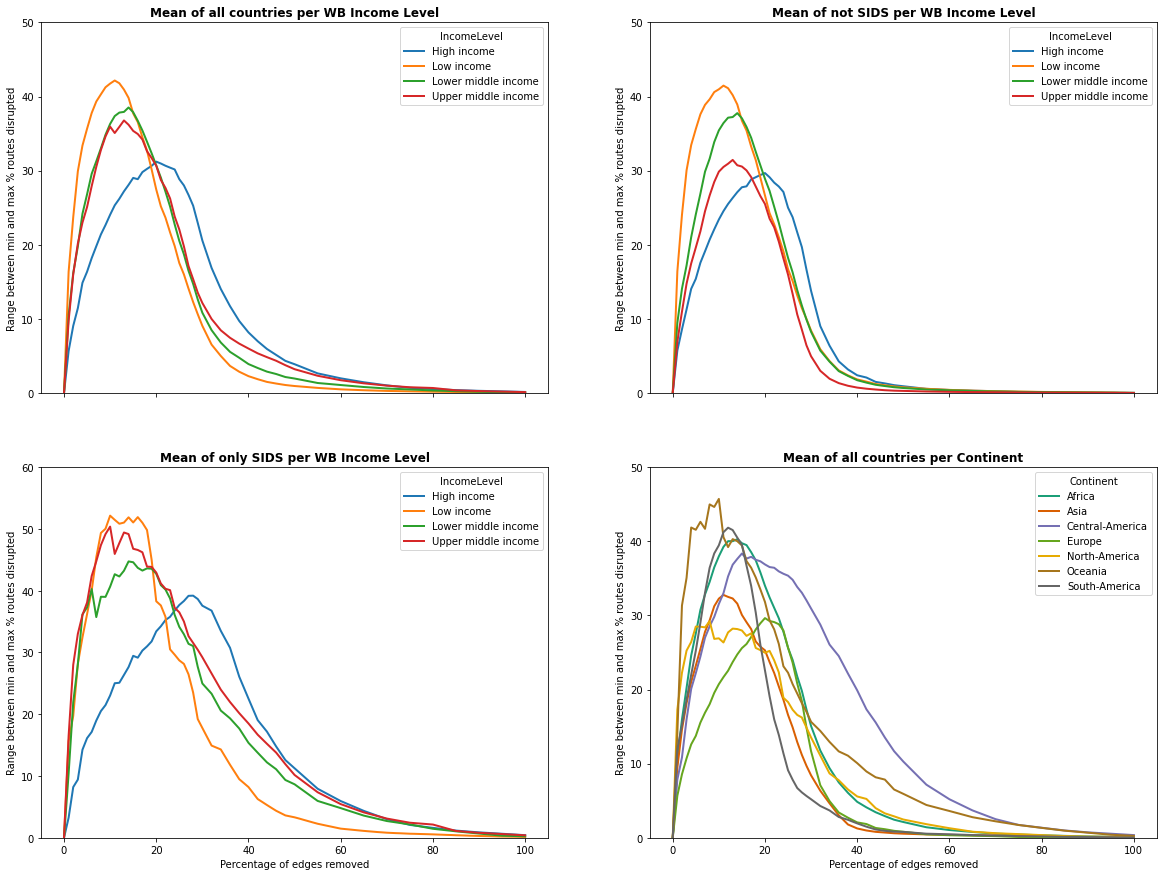

In [18]:
fig, axs = plt.subplots(2,2,figsize=(20,15),sharex=True)

for iter2,ax in enumerate(axs.flatten()):
    if iter2 == 0:
        pd.DataFrame(random_max_isolated.groupby('IncomeLevel').mean().T[:101]-random_min_isolated.groupby('IncomeLevel').mean().T[:101]).plot(ax=ax,linewidth=2)
        ax.set_title('Mean of all countries per WB Income Level',fontweight='bold')
        ax.set_ylim([0,50])
        
    elif iter2 == 1:
        pd.DataFrame(random_max_isolated.loc[random_max_isolated.SIDS==0].groupby('IncomeLevel').mean().T[:101]-random_min_isolated.loc[random_min_isolated.SIDS==0].groupby('IncomeLevel').mean().T[:101]).plot(ax=ax,linewidth=2)
        ax.set_title('Mean of not SIDS per WB Income Level',fontweight='bold')
        ax.set_ylim([0,50])        
        
    elif iter2 == 2:
        pd.DataFrame(random_max_isolated.loc[random_max_isolated.SIDS==1].groupby('IncomeLevel').mean().T[:101]-random_min_isolated.loc[random_min_isolated.SIDS==1].groupby('IncomeLevel').mean().T[:101]).plot(ax=ax,linewidth=2)
        ax.set_title('Mean of only SIDS per WB Income Level',fontweight='bold')
        ax.set_ylim([0,60])      
    
    elif iter2 == 3:
        pd.DataFrame(random_max_isolated.groupby('Continent').mean().T[:101]-random_min_isolated.groupby('Continent').mean().T[:101]).plot(ax=ax,cmap='Dark2',linewidth=2)
        ax.set_title('Mean of all countries per Continent',fontweight='bold')     
        ax.set_ylim([0,50])

    ax.set_xlabel('Percentage of edges removed')
    ax.set_ylabel('Range between min and max % routes disrupted')        
        

In [19]:
random_mean_isolated['Edge_Area'] = random_mean_isolated.Total_Edge_Length/random_mean_isolated.AreaKM
random_min_isolated['Edge_Area'] = random_min_isolated.Total_Edge_Length/random_min_isolated.AreaKM
random_max_isolated['Edge_Area'] = random_max_isolated.Total_Edge_Length/random_max_isolated.AreaKM

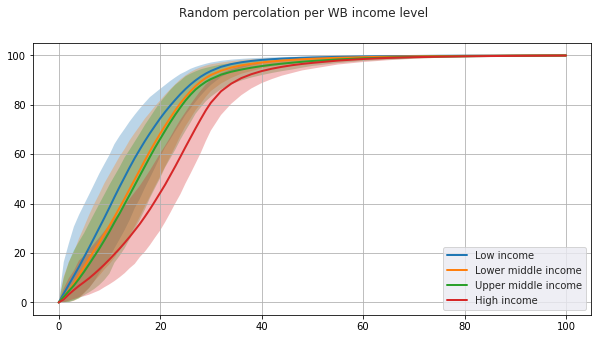

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

clrs = sns.color_palette("tab10")

income_groups = ['Low income','Lower middle income','Upper middle income','High income']

with sns.axes_style("darkgrid"):
    epochs = list(range(101))
    for i in range(4):
        if i == 0:
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Low income']
        elif i == 1:
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
        elif i == 2:
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
        elif i == 3:
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101]['High income']
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101]['High income']
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101]['High income']           
            
        ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
        ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
    ax.legend(loc=4)
    #ax.set_yscale('log')
    
    plt.grid()
    plt.suptitle('Random percolation per WB income level')

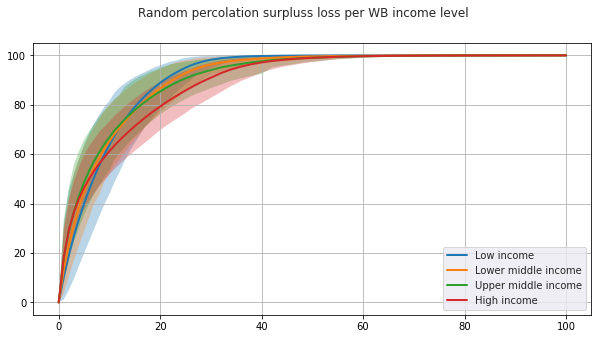

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

clrs = sns.color_palette("tab10")

income_groups = ['Low income','Lower middle income','Upper middle income','High income']

with sns.axes_style("darkgrid"):
    epochs = list(range(101))
    for i in range(4):
        if i == 0:
            meanst = random_mean_sloss.groupby('IncomeLevel').mean().T[:101]['Low income']
            min_plot = random_min_sloss.groupby('IncomeLevel').mean().T[:101]['Low income']
            max_plot = random_max_sloss.groupby('IncomeLevel').mean().T[:101]['Low income']
        elif i == 1:
            meanst = random_mean_sloss.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
            min_plot = random_min_sloss.groupby('IncomeLevel').mean().T[:101]['Lower middle income']
            max_plot = random_max_sloss.groupby('IncomeLevel').mean().T[:101]['Lower middle income']          
        elif i == 2:
            meanst = random_mean_sloss.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
            min_plot = random_min_sloss.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
            max_plot = random_max_sloss.groupby('IncomeLevel').mean().T[:101]['Upper middle income']
        elif i == 3:
            meanst = random_mean_sloss.groupby('IncomeLevel').mean().T[:101]['High income']
            min_plot = random_min_sloss.groupby('IncomeLevel').mean().T[:101]['High income']
            max_plot = random_max_sloss.groupby('IncomeLevel').mean().T[:101]['High income']           
            
        ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
        ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
    ax.legend(loc=4)
    #ax.set_yscale('log')
    
    plt.grid()
    plt.suptitle('Random percolation surpluss loss per WB income level')

In [25]:
def get_gradients(random_df): 
    collect_mean_gradient = {}
    collect_100_point = {}
    for column in random_df.T[:101].columns:
        points = random_df.T[:101][column].values
        collect_mean_gradient[column] = np.argmax(np.abs(np.gradient(points))),np.max(np.abs(np.gradient(points)))
        collect_100_point[column] = np.argmax(np.abs((points)))
        
    return collect_mean_gradient,collect_100_point

collect_mean_gradient,collect_100_point = get_gradients(random_mean_isolated)
random_mean_isolated = random_mean_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_mean_isolated = random_mean_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_mean_isolated['logGDP'] = np.log(random_mean_isolated.GDP_CAP)
random_mean_isolated['logPOP'] = np.log(random_mean_isolated.population)

collect_mean_gradient,collect_100_point = get_gradients(random_min_isolated)
random_min_isolated = random_min_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_min_isolated = random_min_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_min_isolated['logGDP'] = np.log(random_min_isolated.GDP_CAP)
random_min_isolated['logPOP'] = np.log(random_min_isolated.population)


collect_mean_gradient,collect_100_point = get_gradients(random_max_isolated)
random_max_isolated = random_max_isolated.join(pd.DataFrame.from_dict(collect_mean_gradient,orient='index',columns=['loc_max_gradient','max_gradient']))
random_max_isolated = random_max_isolated.join(pd.DataFrame.from_dict(collect_100_point,columns=['loc_100perc'],orient='index'))
random_max_isolated['logGDP'] = np.log(random_max_isolated.GDP_CAP)
random_max_isolated['logPOP'] = np.log(random_max_isolated.population)


In [26]:
random_mean_isolated['POP_AREA'] = random_mean_isolated.population/random_mean_isolated.AreaKM
random_min_isolated['POP_AREA'] = random_min_isolated.population/random_min_isolated.AreaKM
random_max_isolated['POP_AREA'] = random_max_isolated.population/random_min_isolated.AreaKM

In [27]:
#05
local_results_05 = pd.DataFrame(collect_local05).T
local_results_05.columns = ['no_grids_05','no_grids_wroads_05','urban_grids_wroads_05','rural_grids_wroads_05',
                           'pct_grids_cause_isolation_05','avg_pct_trips_isolated_05','max_pct_trips_isolated_05',
                            'pct_grids_cause_delay_05','avg_pct_trips_delayed_05','max_pct_trips_delayed_05',
                           'pct_urban_grids_cause_isolation_05','avg_pct_trips_isolated_urban_05','max_pct_trips_isolated_urban_05',
                            'pct_urban_grids_cause_delay_05','avg_pct_trips_delayed_urban_05','max_pct_trips_delayed_urban_05',
                           'pct_rural_grids_cause_isolation_05','avg_pct_trips_isolated_rural_05','max_pct_trips_isolated_rural_05',
                            'pct_rural_grids_cause_delay_05','avg_pct_trips_delayed_rural_05','max_pct_trips_delayed_rural_05']

local_results_05 = local_results_05.astype(float)
local_results_05 = local_results_05.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

#01
local_results_01 = pd.DataFrame(collect_local01).T
local_results_01.columns = ['no_grids_01','no_grids_wroads_01','urban_grids_wroads_01','rural_grids_wroads_01',
                           'pct_grids_cause_isolation_01','avg_pct_trips_isolated_01','max_pct_trips_isolated_01',
                            'pct_grids_cause_delay_01','avg_pct_trips_delayed_01','max_pct_trips_delayed_01',
                           'pct_urban_grids_cause_isolation_01','avg_pct_trips_isolated_urban_01','max_pct_trips_isolated_urban_01',
                            'pct_urban_grids_cause_delay_01','avg_pct_trips_delayed_urban_01','max_pct_trips_delayed_urban_01',
                           'pct_rural_grids_cause_isolation_01','avg_pct_trips_isolated_rural_01','max_pct_trips_isolated_rural_01',
                            'pct_rural_grids_cause_delay_01','avg_pct_trips_delayed_rural_01','max_pct_trips_delayed_rural_01']
local_results_01 = local_results_01.astype(float)
local_results_01 = local_results_01.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)

#005
local_results_005 = pd.DataFrame(collect_local005).T
local_results_005.columns = ['no_grids_005_005','no_grids_wroads_005','urban_grids_wroads_005','rural_grids_wroads_005',
                           'pct_grids_cause_isolation_005','avg_pct_trips_isolated_005','max_pct_trips_isolated_005',
                            'pct_grids_cause_delay_005','avg_pct_trips_delayed_005','max_pct_trips_delayed_005',
                           'pct_urban_grids_cause_isolation_005','avg_pct_trips_isolated_urban_005','max_pct_trips_isolated_urban_005',
                            'pct_urban_grids_cause_delay_005','avg_pct_trips_delayed_urban_005','max_pct_trips_delayed_urban_005',
                           'pct_rural_grids_cause_isolation_005','avg_pct_trips_isolated_rural_005','max_pct_trips_isolated_rural_005',
                            'pct_rural_grids_cause_delay_005','avg_pct_trips_delayed_rural_005','max_pct_trips_delayed_rural']
local_results_005 = local_results_005.astype(float)
local_results_005 = local_results_005.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)


local_results_05['logGDP_CAP'] = np.log(local_results_05.GDP_CAP)
local_results_01['logGDP_CAP'] = np.log(local_results_01.GDP_CAP)
local_results_005['logGDP_CAP'] = np.log(local_results_005.GDP_CAP)

local_results_05['logAREA'] = np.log(local_results_05.AreaKM)
local_results_01['logAREA'] = np.log(local_results_01.AreaKM)
local_results_005['logAREA'] = np.log(local_results_005.AreaKM)

local_results_05['logPOP'] = np.log(local_results_05.population)
local_results_01['logPOP'] = np.log(local_results_01.population)
local_results_005['logPOP'] = np.log(local_results_005.population)

local_results_05['POP_AREA'] = local_results_05.population/local_results_05.AreaKM
local_results_01['POP_AREA'] = local_results_01.population/local_results_01.AreaKM
local_results_005['POP_AREA'] = local_results_005.population/local_results_005.AreaKM

#target
target_results = pd.DataFrame(collect_target).T
target_results.columns = ['no_edges','pct_edges_cause_isolation','avg_pct_trips_isolated','max_pct_trips_isolated',
                          'pct_edges_cause_delay','avg_pct_trips_delayed','max_pct_trips_delayed']
target_results = target_results.astype(float)
target_results = target_results.join(country_info.groupby('ISO3').first()).dropna(axis=0).join(df_general)
target_results['logGDP_CAP'] = np.log(target_results.GDP_CAP)
target_results['logAREA'] = np.log(target_results.AreaKM)
target_results['logPOP'] = np.log(target_results.population)
target_results['POP_AREA'] = target_results.population/target_results.AreaKM

target_results['logEdges'] = np.log(target_results.no_edges)

In [29]:
local_results_05.to_csv('local_attack_05degree.csv')
local_results_01.to_csv('local_attack_01degree.csv')
local_results_005.to_csv('local_attack_005degree.csv')
target_results.to_csv('targeted_attack.csv')

In [30]:
all_columns_to_jenk = ['AreaKM','Total_Edge_Length','builtarea','POP_AREA','Edge_Area','max_slope','mean_slope']

for column_to_jenk in all_columns_to_jenk:
    jenks = random_mean_isolated[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    random_mean_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_mean_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_min_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_min_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    random_max_isolated['{}_binned'.format(column_to_jenk)] = pd.cut(random_max_isolated[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

In [31]:
random_mean_isolated['mean_gradient_0_20'] = np.mean(np.gradient(random_mean_isolated.iloc[:,:20].values,axis=1),axis=1)
random_max_isolated['mean_gradient_0_20'] = np.mean(np.gradient(random_max_isolated.iloc[:,:20].values,axis=1),axis=1)
random_min_isolated['mean_gradient_0_20'] = np.mean(np.gradient(random_min_isolated.iloc[:,:20].values,axis=1),axis=1)

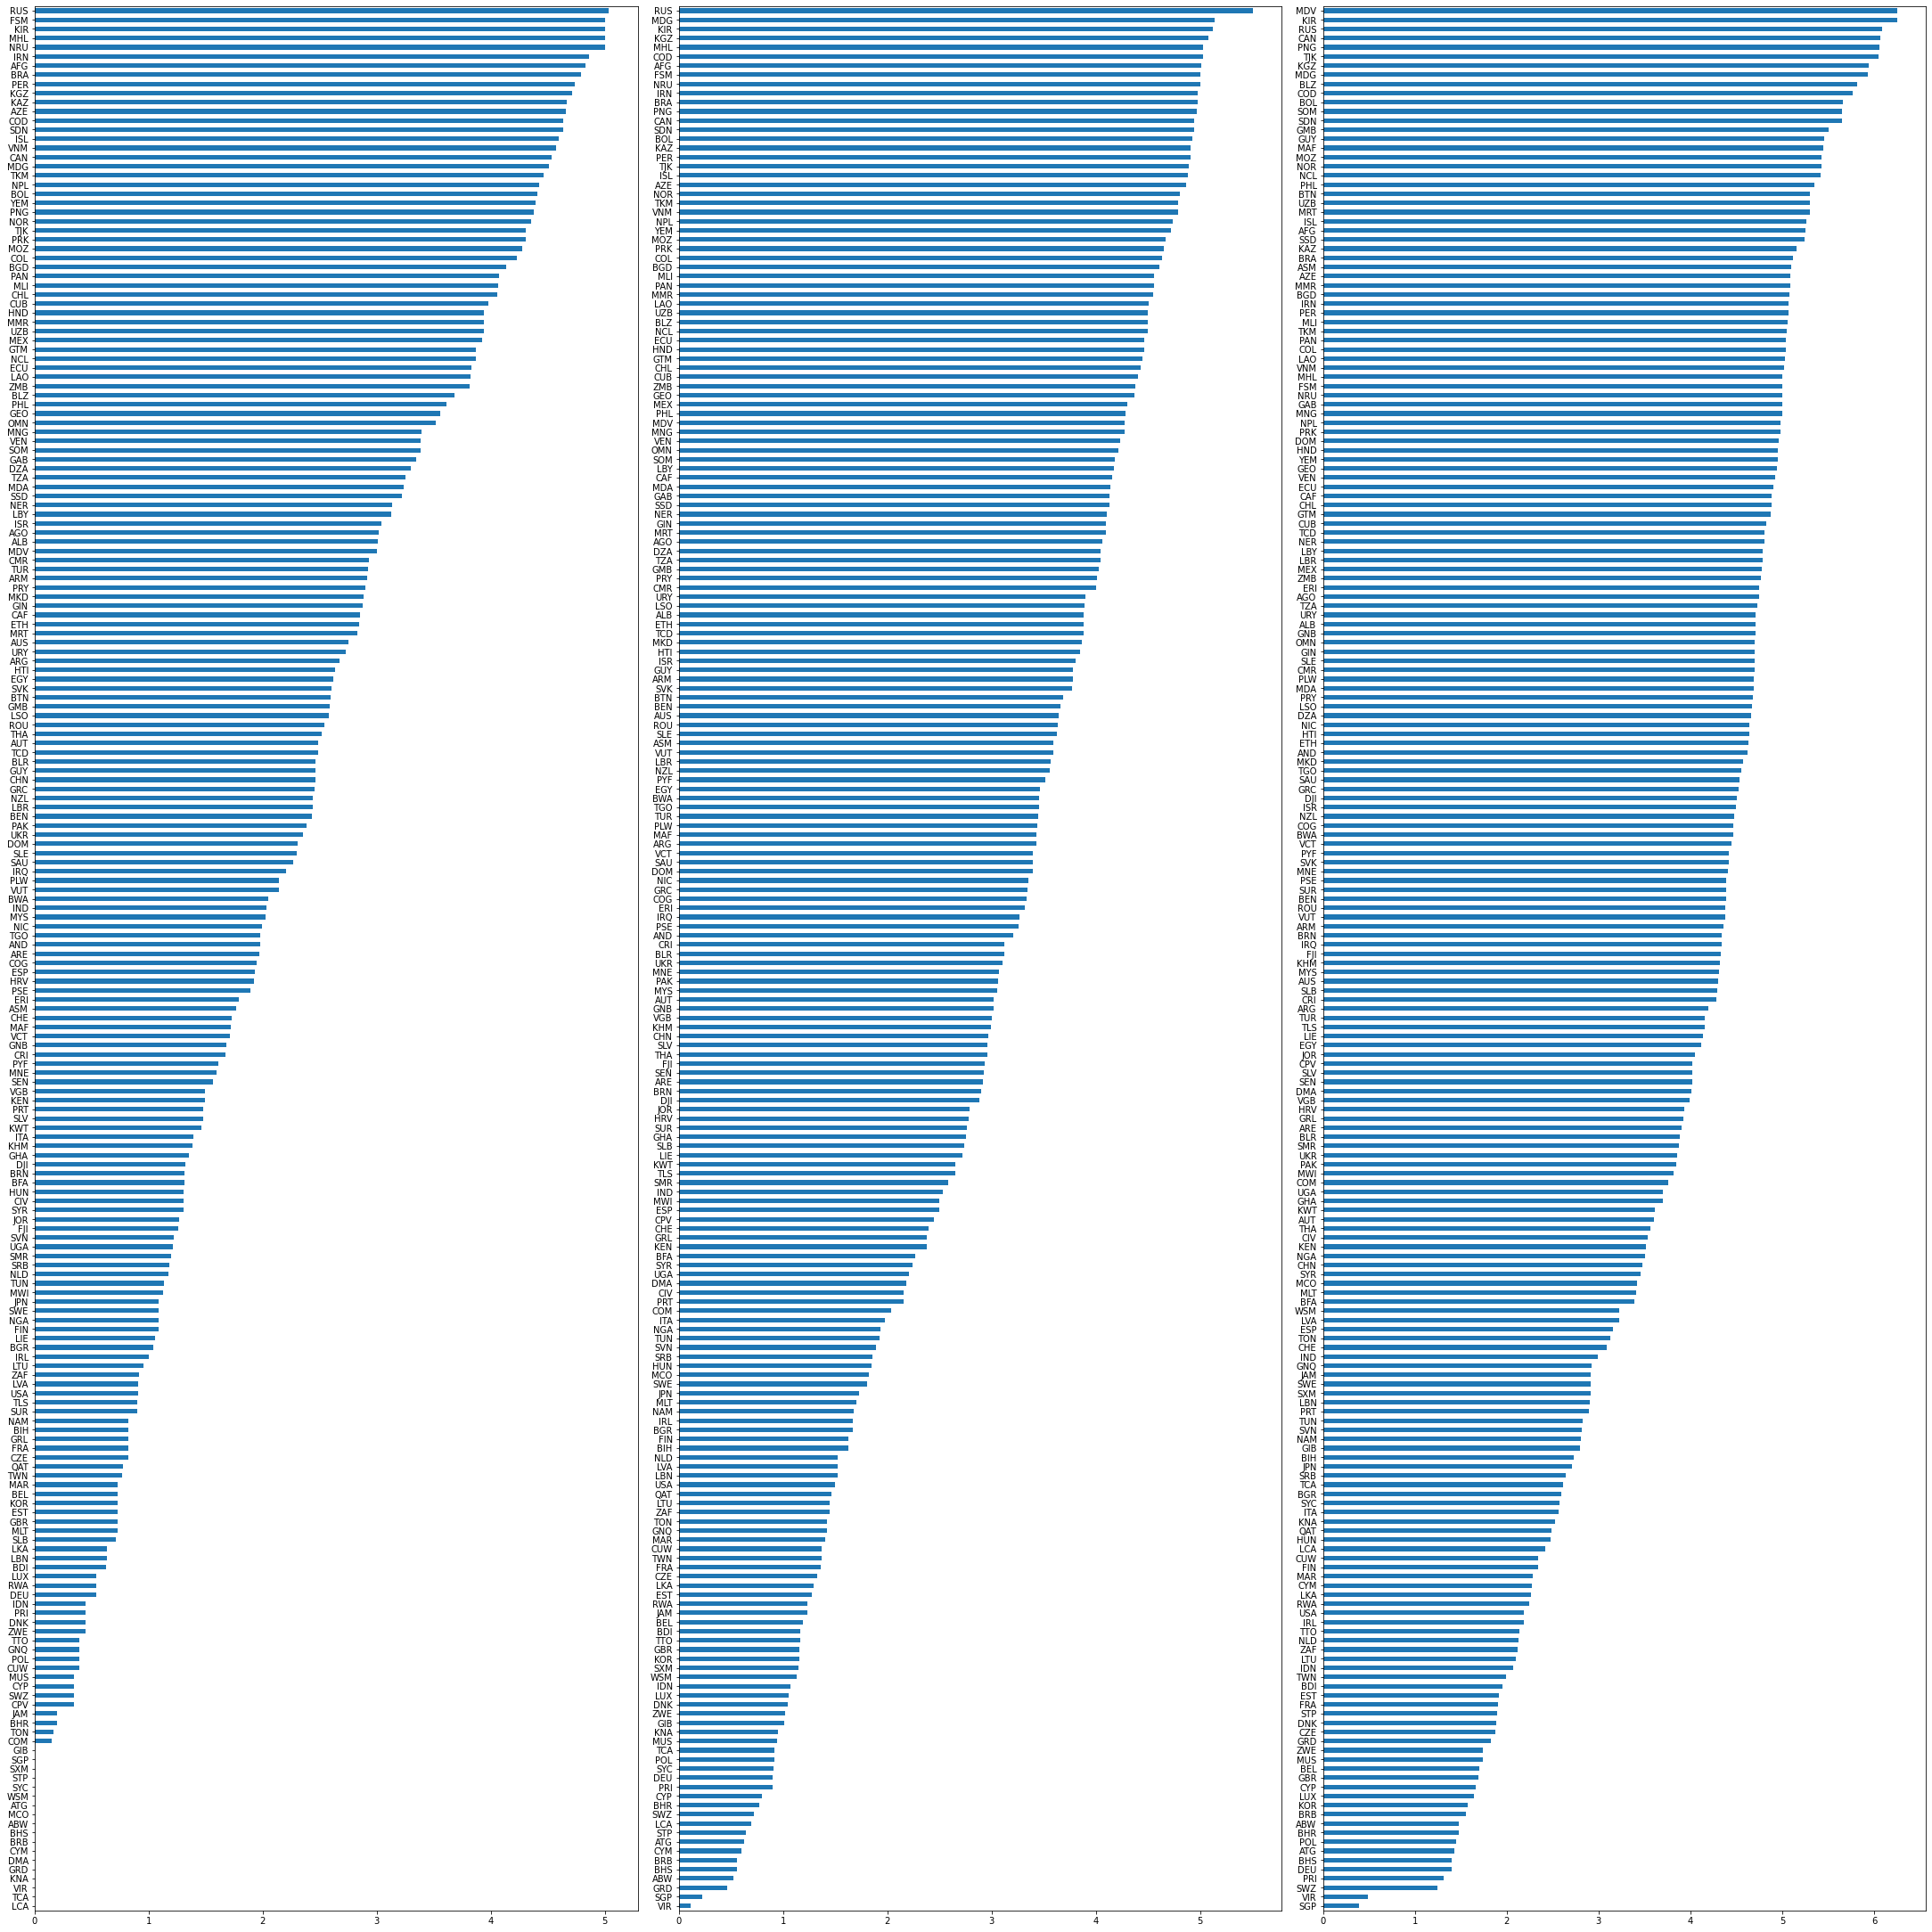

In [32]:
fig,axs = plt.subplots(1,3,figsize=(30,30),constrained_layout=True)

for iter_,ax in enumerate(axs):
    if iter_ == 0:
        random_min_isolated.mean_gradient_0_20.sort_values().plot(kind='barh',ax=ax)
    elif iter_ == 1:
        random_mean_isolated.mean_gradient_0_20.sort_values().plot(kind='barh',ax=ax)
    elif iter_ == 2:
        random_max_isolated.mean_gradient_0_20.sort_values().plot(kind='barh',ax=ax)        

In [33]:
letters = ['A','B','C','D','E','F','G','H']

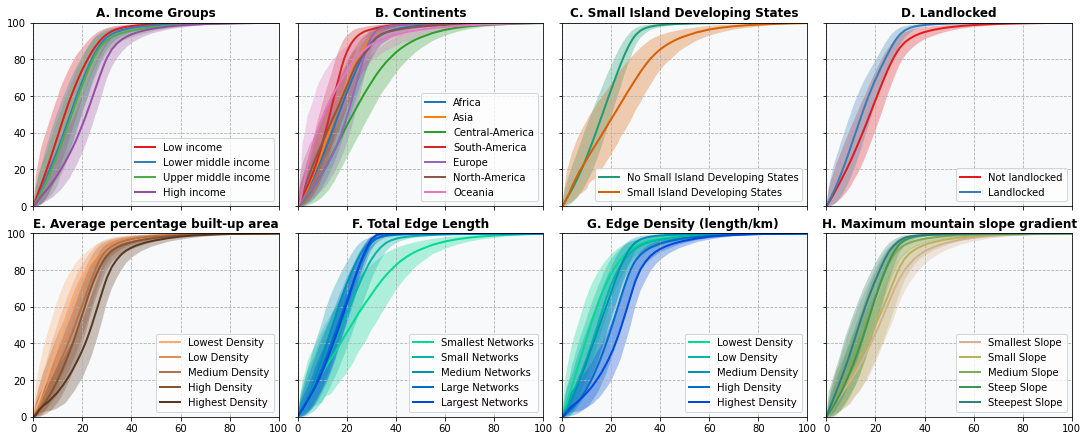

In [34]:
fig,axs = plt.subplots(2,4,figsize=(15,6),sharex=True,sharey=True,constrained_layout=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_isolated.groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('{}. Income Groups'.format(letters[iter_]),fontweight='bold')
    elif iter_ == 1: #continents
        clrs = sns.color_palette("tab10")

        continents = ['Africa', 'Asia', 'Central-America', 'South-America', 'Europe', 'North-America',
               'Oceania']

        for i in range(len(continents)):
            meanst = random_mean_isolated.groupby('Continent').mean().T[:101][continents[i]]
            min_plot = random_min_isolated.groupby('Continent').mean().T[:101][continents[i]]
            max_plot = random_max_isolated.groupby('Continent').mean().T[:101][continents[i]]

            ax.plot(epochs, meanst, label=continents[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)

        ax.set_title('{}. Continents'.format(letters[iter_]),fontweight='bold')
           
    elif iter_ == 2: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_isolated.groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Small Island Developing States'.format(letters[iter_]),fontweight='bold')
            
    elif iter_ == 3: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
        
    elif iter_ == 4: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Average percentage built-up area'.format(letters[iter_]),fontweight='bold')
            
    elif iter_ == 5: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Total Edge Length'.format(letters[iter_]),fontweight='bold')

    elif iter_ == 6: # Edge/Area
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.groupby('Edge_Area_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Edge Density (length/km) '.format(letters[iter_]),fontweight='bold')        
        
    elif iter_ == 7: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
            
    ax.tick_params(axis='both', which='major', labelsize=10)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)
    ax.set_ylim(0,100) 
    ax.set_xlim(0,100)        
    
plt.savefig('Random_attack_grouped.png',dpi=500,facecolor='white', bbox_inches='tight')


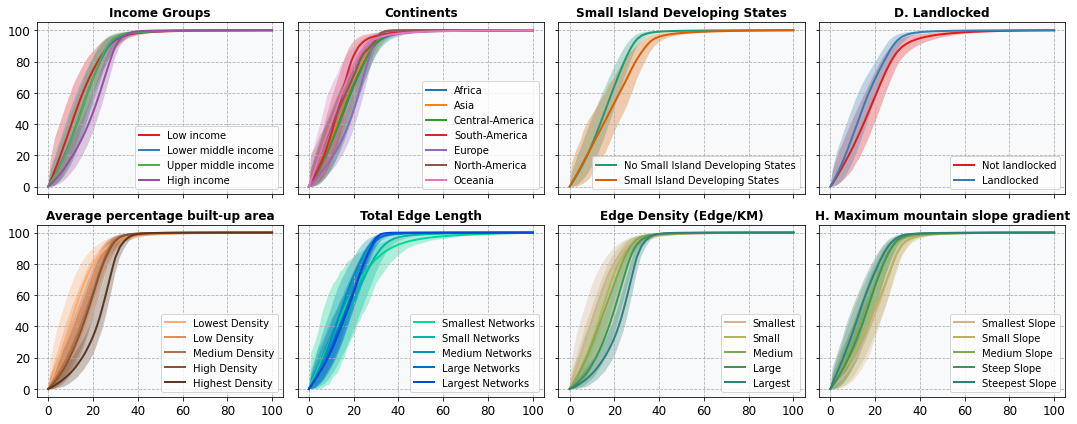

In [35]:
fig,axs = plt.subplots(2,4,figsize=(15,6),sharex=True,sharey=True)

epochs = list(range(101))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0: #income groups
        clrs = sns.color_palette("Set1")

        income_groups = ['Low income','Lower middle income','Upper middle income','High income']
        
        for i in range(len(income_groups)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('IncomeLevel').mean().T[:101][income_groups[i]]
            ax.plot(epochs, meanst, label=income_groups[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)
        
        ax.set_title('Income Groups',fontweight='bold')
    elif iter_ == 1: #continents
        clrs = sns.color_palette("tab10")

        continents = ['Africa', 'Asia', 'Central-America', 'South-America', 'Europe', 'North-America',
               'Oceania']

        for i in range(len(continents)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Continent').mean().T[:101][continents[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Continent').mean().T[:101][continents[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Continent').mean().T[:101][continents[i]]

            ax.plot(epochs, meanst, label=continents[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)

        ax.set_title('Continents',fontweight='bold')
           
    elif iter_ == 2: #islands
        clrs = sns.color_palette("Dark2")
        
        SIDS = [0,1]
        SIDS_labels = ['No Small Island Developing States','Small Island Developing States']

        for i in range(len(SIDS)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('SIDS').mean().T[:101][SIDS[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('SIDS').mean().T[:101][SIDS[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('SIDS').mean().T[:101][SIDS[i]]


            ax.plot(epochs, meanst, label=SIDS_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Small Island Developing States',fontweight='bold')

    elif iter_ == 3: #landlocked
        clrs = sns.color_palette("Set1")

        landlocked = [0,1]
        landlocked_labels = ['Not landlocked','Landlocked']

        for i in range(len(landlocked)):
            meanst = random_mean_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            min_plot = random_min_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]
            max_plot = random_max_isolated.groupby('landlocked').mean().T[:101][landlocked[i]]


            ax.plot(epochs, meanst, label=landlocked_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('{}. Landlocked'.format(letters[iter_]),fontweight='bold')
    
    
    elif iter_ == 4: #builtup area
        clrs = sns.color_palette("copper_r")

        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('builtarea_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('builtarea_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Average percentage built-up area',fontweight='bold')
            
    elif iter_ == 5: #Total Edge Length
        clrs = sns.color_palette("winter_r")
        
        edge_length = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        edge_length_labels = ['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Total_Edge_Length_binned').mean().T[:101][edge_length[i]]


            ax.plot(epochs, meanst, label=edge_length_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          

        ax.set_title('Total Edge Length',fontweight='bold')
            
    elif iter_ == 6: #Pop Density
        clrs = sns.color_palette("gist_earth_r")
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Lowest Density', 'Low Density', 'Medium Density', 'High Density','Highest Density']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Edge_Area_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Edge_Area_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('Edge_Area_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('Edge Density (Edge/KM)',fontweight='bold')

    elif iter_ == 7: #Mountain Slope
        clrs = sns.color_palette("gist_earth_r")
        
        builtup = ['Smallest', 'Small', 'Medium', 'Large','Largest']
        builtup_labels = ['Smallest Slope', 'Small Slope', 'Medium Slope', 'Steep Slope','Steepest Slope']

        for i in range(len(builtup)):
            meanst = random_mean_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            min_plot = random_min_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('max_slope_binned').mean().T[:101][builtup[i]]
            max_plot = random_max_isolated.loc[random_mean_isolated.Total_Edge_Length > 1e6].groupby('max_slope_binned').mean().T[:101][builtup[i]]


            ax.plot(epochs, meanst, label=builtup_labels[i], c=clrs[i], linewidth=2)
            ax.fill_between(epochs, min_plot, max_plot ,alpha=0.3, facecolor=clrs[i],linewidth=1)          
            
        ax.set_title('{}. Maximum mountain slope gradient'.format(letters[iter_]),fontweight='bold')
    
    
    ax.tick_params(axis='both', which='major', labelsize=12)   
    ax.grid(True, linestyle='--')    
    ax.set_facecolor('#f8f9fa')        
    ax.legend(loc=4)

    plt.tight_layout()

No handles with labels found to put in legend.


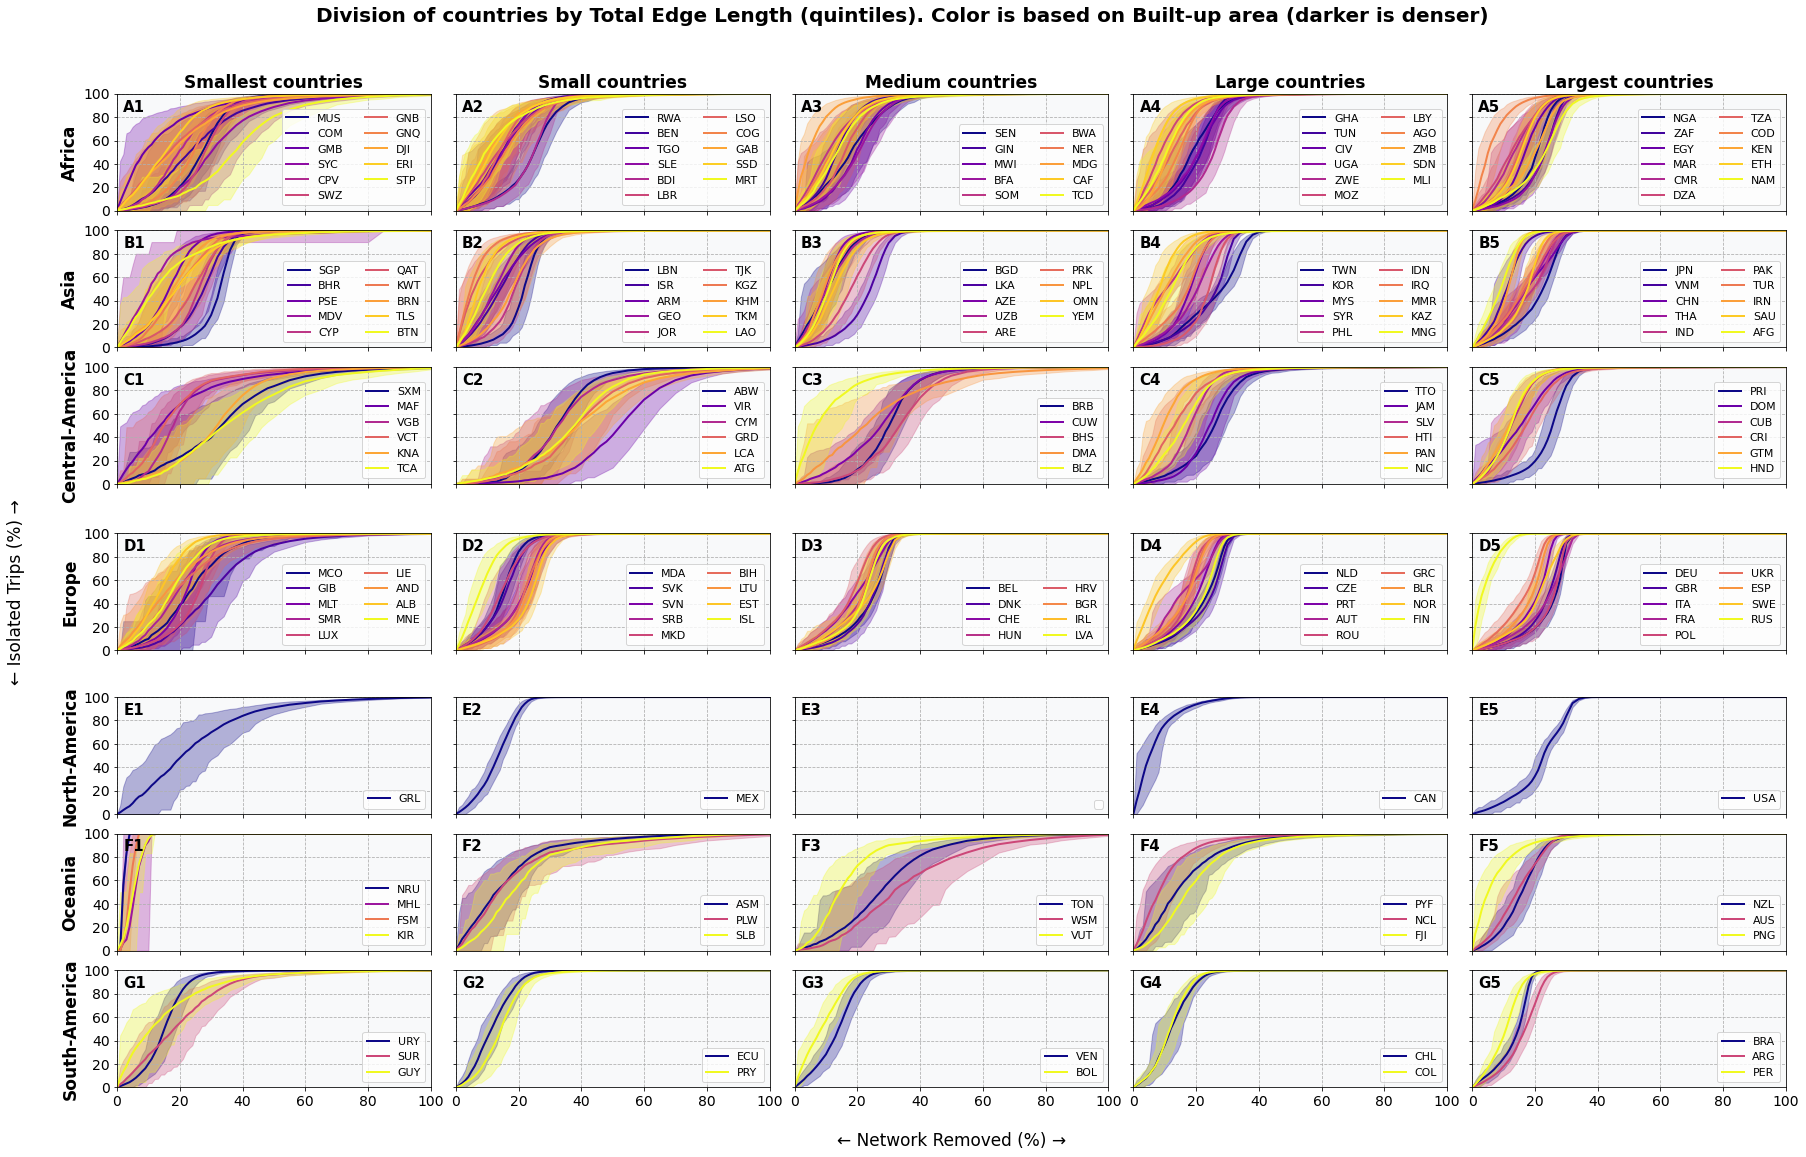

In [36]:
fig,axs = plt.subplots(7,5,figsize=(25,15),sharex=True,sharey=True,constrained_layout=True)
epochs = list(range(101))

iter_= 0

for cont_mean,cont_min,cont_max in zip(random_mean_isolated.groupby(['Continent']),
                                        random_min_isolated.groupby(['Continent']),random_max_isolated.groupby(['Continent'])):
    dfmean = cont_mean[1]
    dfmin = cont_min[1]
    dfmax = cont_max[1]
    
    column_to_jenk = 'Total_Edge_Length'
    jenks = dfmean[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dfmean['{}_binned'.format(column_to_jenk)] = pd.cut(dfmean[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmin['{}_binned'.format(column_to_jenk)] = pd.cut(dfmin[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmax['{}_binned'.format(column_to_jenk)] = pd.cut(dfmax[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])   
    
    axs[iter_,0].set_ylabel(cont_mean[0],fontsize=17,fontweight='bold')
    axs[iter_,0].set_yticks(np.arange(0,101,20))
    
    for iter2_,group in enumerate(dfmean.groupby(['{}_binned'.format(column_to_jenk)])):
        grouped = group[1].T[:101]  
        
        meanst = dfmean.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        min_plot = dfmin.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        max_plot = dfmax.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)

        cmap = cm.get_cmap('plasma', len(meanst.columns)) 

        for x in range(len(meanst.columns)):
            axs[iter_,iter2_].plot(epochs, meanst.iloc[:,x],label=meanst.columns[x],color=cmap(x), linewidth=2)
            axs[iter_,iter2_].fill_between(epochs, min_plot.iloc[:,x], max_plot.iloc[:,x],color=cmap(x) ,alpha=0.3, linewidth=1)

        if (len(min_plot.columns) > 7):
            axs[iter_,iter2_].legend(ncol=2,loc=4,prop={'size': 11})
        else:
            axs[iter_,iter2_].legend(loc=4,prop={'size': 11})

        axs[0,iter2_].set_title("{} countries".format(group[0]),fontsize=17,fontweight='bold')
            
        axs[iter_,iter2_].tick_params(axis='both', which='major', labelsize=14)   
        axs[iter_,iter2_].grid(True, linestyle='--')    
        axs[iter_,iter2_].set_facecolor('#f8f9fa')
        axs[iter_,iter2_].set_ylim(0,100) 
        axs[iter_,iter2_].set_xlim(0,100)        
        axs[iter_,iter2_].text(2,85,"{}{}".format(letters[iter_],iter2_+1),fontsize=15,fontweight='bold')
        #axs[iter_,iter2_].set_title("{}'s {}-sized countries.".format(cont_mean[0],group[0]),fontsize=14)
    iter_ += 1                                   
        
axs[6,2].text(50,-50,'\u2190 Network Removed (%) \u2192',ha='center',fontsize=17)
axs[3,0].text(-35,50,'\u2190 Isolated Trips (%) \u2192',va='center',fontsize=17,rotation=90)

#axs[0,3].text(-0.5,-0.3,'\u2190 Isolated Trips (%) \u2192',transform=axs[0,3].transAxes,ha='center',fontsize=15)
#axs[6,3].text(-0.5,0.1,'\u2190 Network removed (%) \u2192',transform=axs[6,3].transAxes,ha='center',rotation=90,fontsize=15) 

plt.suptitle('Division of countries by Total Edge Length (quintiles). Color is based on Built-up area (darker is denser)',fontsize=20,y=1.06,fontweight='bold')

plt.savefig('AreaSizeDivision_bycontinent.png',dpi=500,facecolor='white', bbox_inches='tight')

No handles with labels found to put in legend.


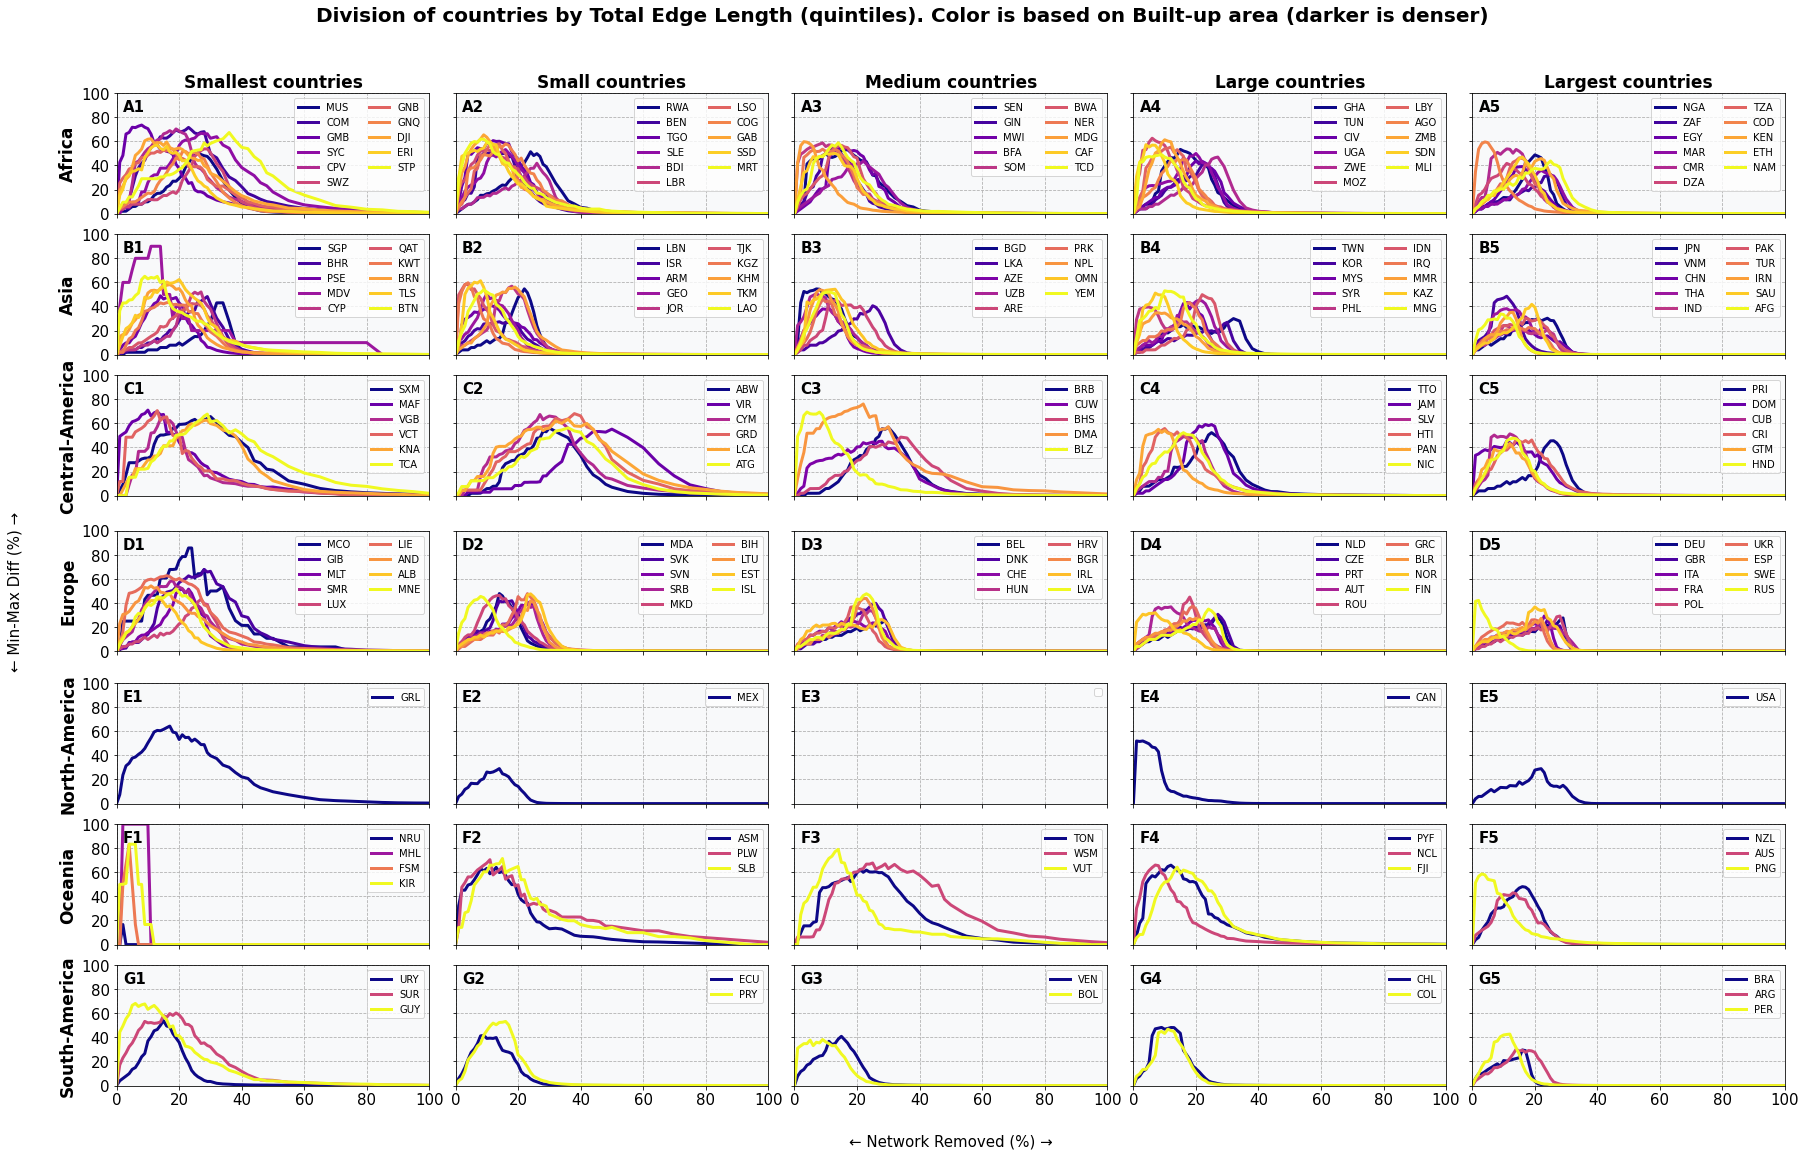

In [37]:
fig,axs = plt.subplots(7,5,figsize=(25,15),sharex=True,sharey=True,constrained_layout=True)
epochs = list(range(101))

iter_= 0
for cont_mean,cont_min,cont_max in zip(random_mean_isolated.groupby(['Continent']),
                                        random_min_isolated.groupby(['Continent']),random_max_isolated.groupby(['Continent'])):
    dfmean = cont_mean[1]
    dfmin = cont_min[1]
    dfmax = cont_max[1]
    
    column_to_jenk = 'Total_Edge_Length'
    jenks = dfmean[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dfmean['{}_binned'.format(column_to_jenk)] = pd.cut(dfmean[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmin['{}_binned'.format(column_to_jenk)] = pd.cut(dfmin[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])

    dfmax['{}_binned'.format(column_to_jenk)] = pd.cut(dfmax[column_to_jenk], 
                                                                      bins=[0]+list(jenks), labels=['Smallest', 'Small', 'Medium', 'Large','Largest'])   
    
    axs[iter_,0].set_ylabel(cont_mean[0],fontsize=17,fontweight='bold')
    axs[iter_,0].set_yticks(np.arange(0,101,20))
    
    for iter2_,group in enumerate(dfmean.groupby(['{}_binned'.format(column_to_jenk)])):
        grouped = group[1].T[:101]  
        
        meanst = dfmean.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        min_plot = dfmin.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)
        max_plot = dfmax.loc[grouped.columns.values].sort_values('builtarea',ascending=False).T[:101].astype(float)

        diff = max_plot-min_plot
        cmap = cm.get_cmap('plasma', len(meanst.columns)) 

        #['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']#cm.get_cmap('plasma', len(meanst.columns)) 

        for x in range(len(meanst.columns)):
            axs[iter_,iter2_].plot(epochs,diff.iloc[:,x],label=diff.columns[x],color=cmap(x), linewidth=3)
            #axs[iter_,iter2_].fill_between(epochs, min_plot.iloc[:,x], max_plot.iloc[:,x],color=cmap(x) ,alpha=0.3, linewidth=1)

        if (len(min_plot.columns) > 7):
            axs[iter_,iter2_].legend(ncol=2,loc=1,prop={'size': 10})
        else:
            axs[iter_,iter2_].legend(loc=1,prop={'size': 10})

        axs[0,iter2_].set_title("{} countries".format(group[0]),fontsize=17,fontweight='bold')
            
        axs[iter_,iter2_].tick_params(axis='both', which='major', labelsize=15)   
        axs[iter_,iter2_].grid(True, linestyle='--')           
        axs[iter_,iter2_].set_facecolor('#f8f9fa')
        axs[iter_,iter2_].set_ylim(0,100) 
        axs[iter_,iter2_].set_xlim(0,100)        
        axs[iter_,iter2_].text(2,85,"{}{}".format(letters[iter_],iter2_+1),fontsize=15,fontweight='bold')
                #axs[iter_,iter2_].set_title("{}'s {}-sized countries.".format(cont_mean[0],group[0]),fontsize=14)
    iter_ += 1                                   

axs[6,2].text(50,-50,'\u2190 Network Removed (%) \u2192',ha='center',fontsize=15)
axs[3,0].text(-35,50,'\u2190 Min-Max Diff (%) \u2192',va='center',fontsize=15,rotation=90)
    
#axs[0,3].text(-0.5,-0.3,'\u2190 Isolated Trips (%) \u2192',transform=axs[0,3].transAxes,ha='center',fontsize=15)
#axs[6,3].text(-0.5,0.1,'\u2190 Network removed (%) \u2192',transform=axs[6,3].transAxes,ha='center',rotation=90,fontsize=15) 

plt.suptitle('Division of countries by Total Edge Length (quintiles). Color is based on Built-up area (darker is denser)',fontsize=20,y=1.06,fontweight='bold')

plt.savefig('AreaSizeDivision_bycontinent_minmaxdiff.png',dpi=500,facecolor='white', bbox_inches='tight')


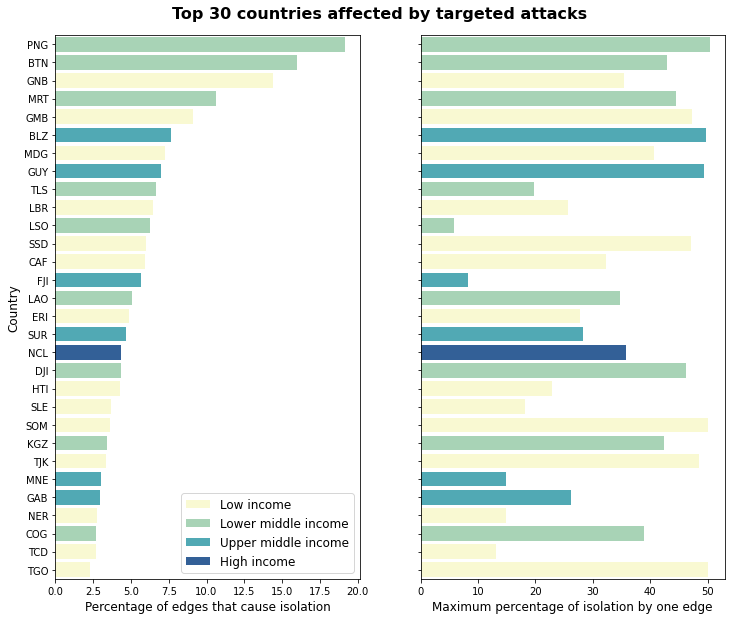

In [38]:
fig,axes = plt.subplots(1,2,figsize=(12,10),sharey=True) 

color_scheme = ['#a1dab4','#ffffcc','#41b6c4','#225ea8'] #,"fe6d73"]

for iter_,ax in enumerate(axes.flatten()):

    if iter_ == 0:
        sns.set_palette(sns.color_palette(color_scheme))

        data = target_results.loc[target_results.Total_Edge_Length > 1e6].sort_values('pct_edges_cause_isolation',ascending=False)[:30]
        sns.barplot(x=data.pct_edges_cause_isolation, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Percentage of edges that cause isolation',fontsize=12)
        ax.set_ylabel('Country',fontsize=12)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[1],handles[0],handles[2],handles[3]]
        labels = [labels[1],labels[0],labels[2],labels[3]]
        ax.legend(handles, labels, loc='lower right',prop={'size': 12})
        
    else:
        sns.set_palette(sns.color_palette(color_scheme))

        data = target_results.loc[target_results.Total_Edge_Length > 1e6].sort_values('pct_edges_cause_isolation',ascending=False)[:30]
        sns.barplot(x=data.max_pct_trips_isolated, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Maximum percentage of isolation by one edge',fontsize=12)

        #handles, labels = ax.get_legend_handles_labels()
        #handles = [handles[1],handles[0],handles[2],handles[3]]
        #labels = [labels[1],labels[0],labels[2],labels[3]]
        #ax.legend(handles, labels, loc='lower right',prop={'size': 12})
        ax.legend([],[], frameon=False)
        
    plt.suptitle("Top 30 countries affected by targeted attacks",fontsize=16,y=0.92,fontweight='bold')

plt.savefig('top30_targetattacks.png',dpi=500,facecolor='white', bbox_inches='tight')


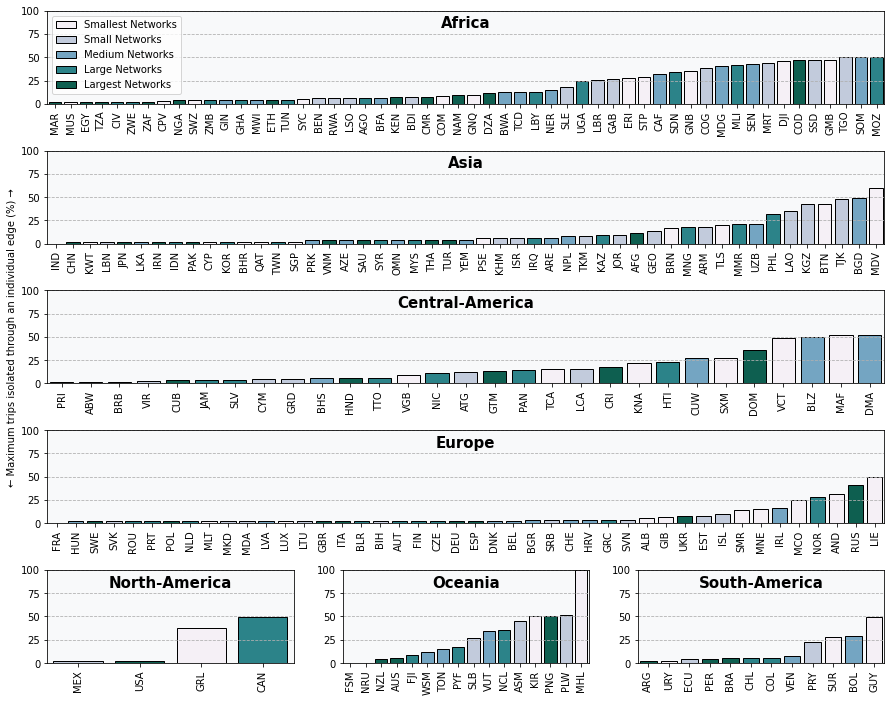

In [39]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59']


for tgroups in target_results.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('max_pct_trips_isolated',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.max_pct_trips_isolated,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,100) 
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Maximum trips isolated through an individual edge (%) \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
#plt.show()
plt.savefig('allcountries_targetattacks_maxtripsisolated.png',dpi=500,facecolor='white', bbox_inches='tight')


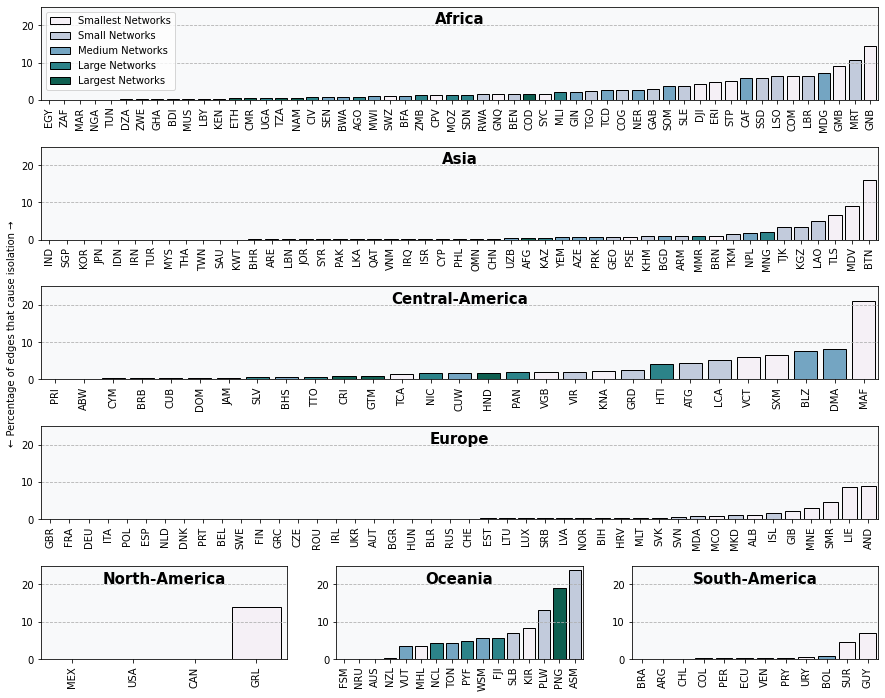

In [40]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59']


for tgroups in target_results.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('pct_edges_cause_isolation',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.pct_edges_cause_isolation,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,25)
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Percentage of edges that cause isolation \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
plt.savefig('allcountries_targetattacks_edgescauseisolation.png',dpi=500,facecolor='white', bbox_inches='tight')

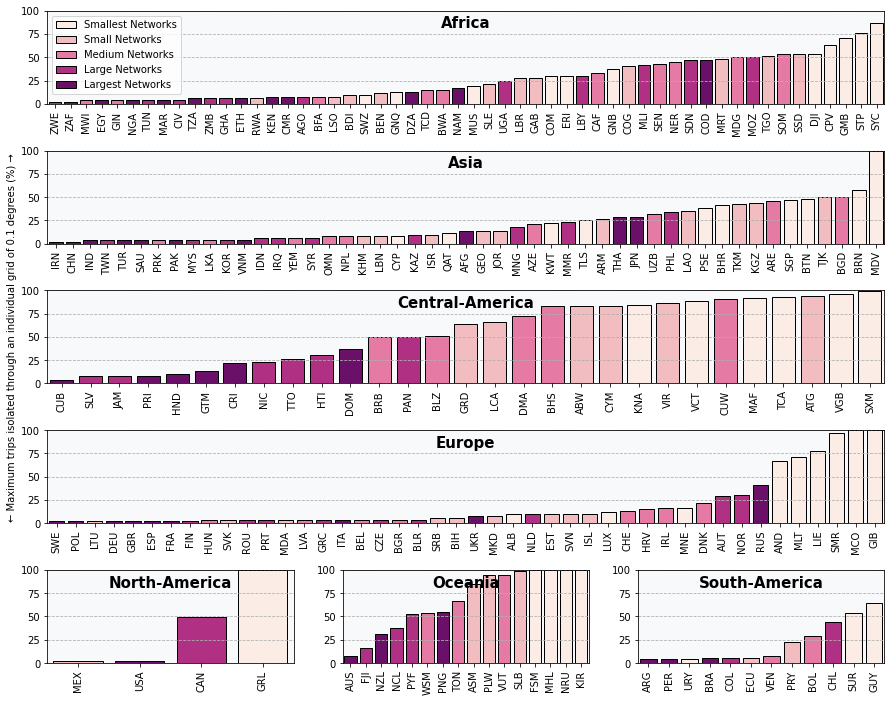

In [41]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#feebe2','#fbb4b9','#f768a1','#c51b8a','#7a0177']


for tgroups in local_results_01.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('max_pct_trips_isolated_01',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.max_pct_trips_isolated_01,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,100) 
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Maximum trips isolated through an individual grid of 0.1 degrees (%) \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
plt.savefig('allcountries_localattack01_maxtripsisolated.png',dpi=500,facecolor='white', bbox_inches='tight')


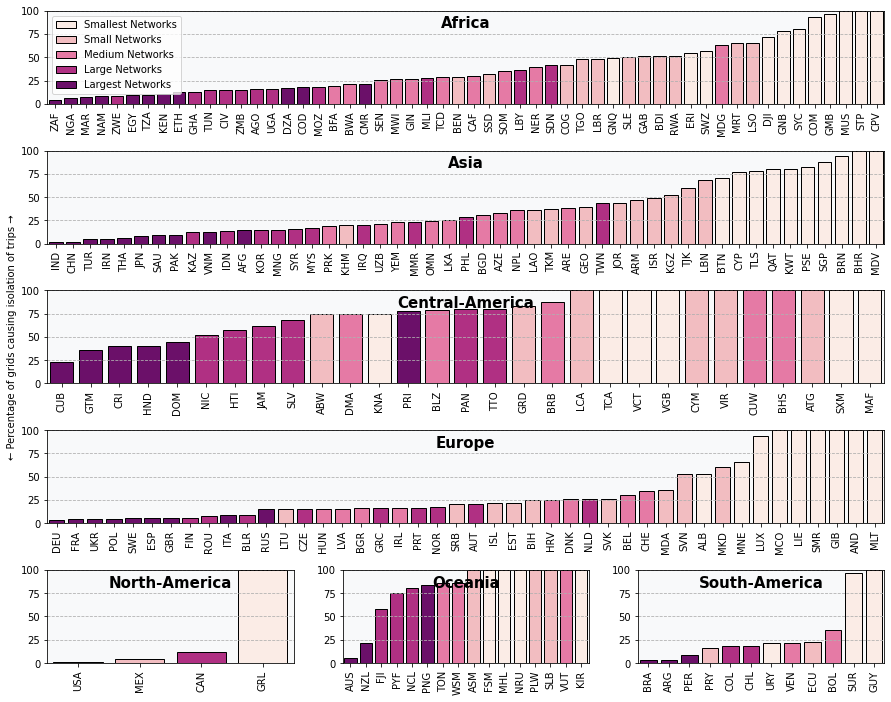

In [42]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#feebe2','#fbb4b9','#f768a1','#c51b8a','#7a0177']


for tgroups in local_results_01.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('pct_grids_cause_isolation_01',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.pct_grids_cause_isolation_01,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,100) 
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Percentage of grids causing isolation of trips \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
plt.savefig('allcountries_localattack01_gridscauseisolation.png',dpi=500,facecolor='white', bbox_inches='tight')


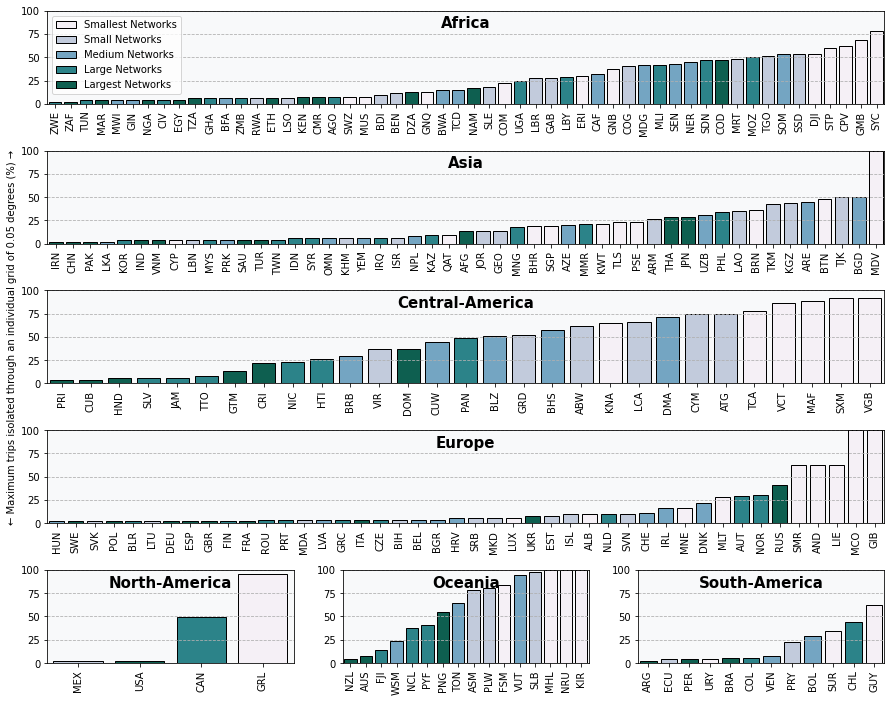

In [43]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59']


for tgroups in local_results_005.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('max_pct_trips_isolated_005',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.max_pct_trips_isolated_005,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,100) 
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Maximum trips isolated through an individual grid of 0.05 degrees (%) \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
plt.savefig('allcountries_localattack005_maxtripsisolated.png',dpi=500,facecolor='white', bbox_inches='tight')


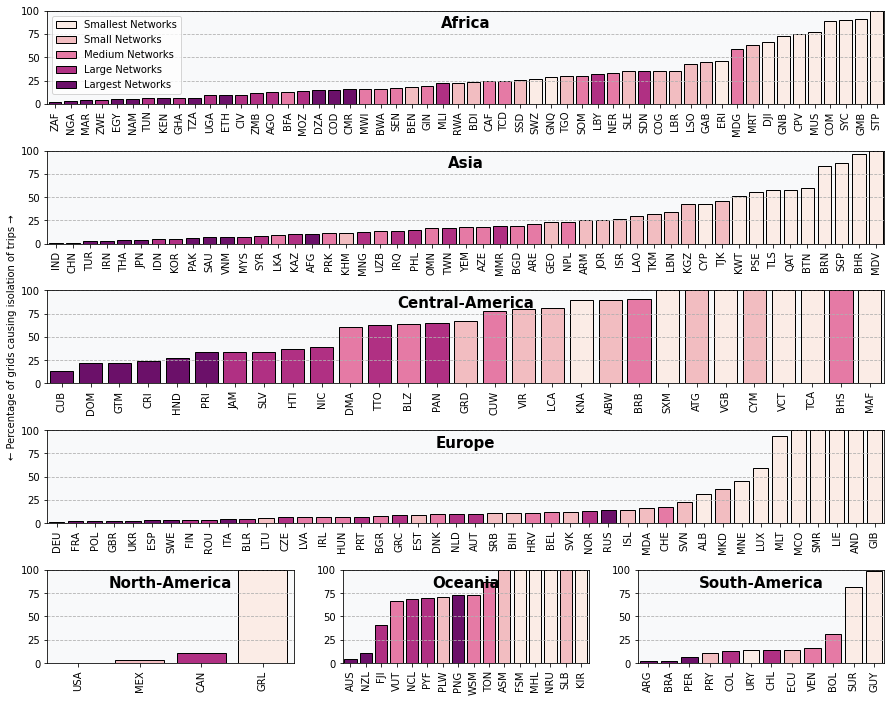

In [44]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15,12))

gs = GridSpec(5, 3, hspace=0.5)

ax1 = fig.add_subplot(gs[:1, :])
ax2 = fig.add_subplot(gs[1:2, :])
ax3 = fig.add_subplot(gs[2:3, :])
ax4 = fig.add_subplot(gs[3:4, :])
ax5 = fig.add_subplot(gs[4:5, 0])
ax6 = fig.add_subplot(gs[4:5, 1])
ax7 = fig.add_subplot(gs[4:5, 2])

axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]

iter_= 0

color_scheme =['#feebe2','#fbb4b9','#f768a1','#c51b8a','#7a0177']


for tgroups in local_results_005.groupby(['Continent']):
    dftarget = tgroups[1]

    column_to_jenk = 'Total_Edge_Length'
    jenks = dftarget[column_to_jenk].quantile([.2, .4, .6, .8, 1.0]).values#jenkspy.jenks_breaks(random_mean_isolated[column_to_jenk], nb_class=4)

    dftarget['{}_binned'.format(column_to_jenk)] = pd.cut(dftarget[column_to_jenk], 
                                                                      bins=[0]+list(jenks), 
                                                          labels=['Smallest Networks', 'Small Networks', 'Medium Networks', 'Large Networks','Largest Networks'])


    meanst = dftarget.sort_values('pct_grids_cause_isolation_005',ascending=True)

#     if len(meanst) == 0:
#         continue

    #meanst.max_pct_trips_isolated.plot(kind='bar',ax=axs[iter_],color=cmap.colors)
    sns.barplot(y=meanst.pct_grids_cause_isolation_005,x=meanst.index,
                hue=meanst['{}_binned'.format(column_to_jenk)],palette=sns.set_palette(sns.color_palette(color_scheme)), 
                ax=axs[iter_],dodge=False,linewidth=1,edgecolor='black')
    axs[iter_].set_facecolor('#f8f9fa')
    axs[iter_].set_ylim(0,100) 
    axs[iter_].grid(True, linestyle='--',axis='y')          

    axs[iter_].set_title(tgroups[0],fontweight='bold',fontsize=15,y=0.75)
    axs[iter_].tick_params('x', labelrotation=90) 
#     axs[iter_,0].set_title("{}'s {}-sized countries.".format(tgroups[0],group[0]))     
    
    if iter_ == 2:
        axs[iter_].set_ylabel('\u2190 Percentage of grids causing isolation of trips \u2192')
    else:
        axs[iter_].set_ylabel('')
        


    if iter_ == 0:
        handles, labels = axs[iter_].get_legend_handles_labels()
        axs[iter_].legend(handles, labels, loc='upper left',prop={'size': 10})
    else:
        axs[iter_].legend([],[], frameon=False)
        
    iter_ += 1      
    
plt.savefig('allcountries_localattack005_gridscauseisolation.png',dpi=500,facecolor='white', bbox_inches='tight')


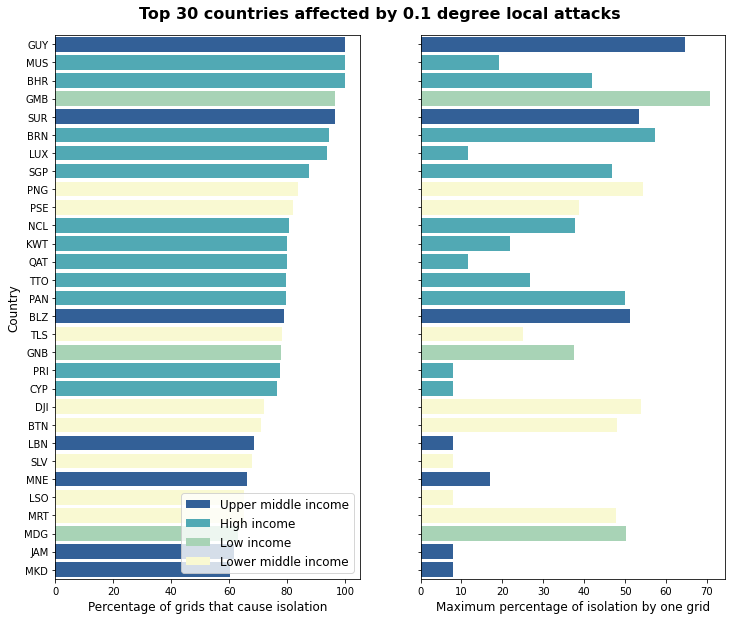

In [45]:
fig,axes = plt.subplots(1,2,figsize=(12,10),sharey=True) 

color_scheme = ['#225ea8','#41b6c4','#a1dab4','#ffffcc'] #,"fe6d73"]

for iter_,ax in enumerate(axes.flatten()):

    if iter_ == 0:
        sns.set_palette(sns.color_palette(color_scheme))

        data = local_results_01.loc[local_results_01.Total_Edge_Length > 1e6].sort_values('pct_grids_cause_isolation_01',ascending=False)[:30]
        sns.barplot(x=data.pct_grids_cause_isolation_01, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Percentage of grids that cause isolation',fontsize=12)
        ax.set_ylabel('Country',fontsize=12)

        #handles, labels = ax.get_legend_handles_labels()
        #handles = [handles[1],handles[0],handles[2],handles[3]]
        #labels = [labels[1],labels[0],labels[2],labels[3]]
        ax.legend(loc='lower right',prop={'size': 12})
        
    else:
        sns.set_palette(sns.color_palette(color_scheme))

        data = local_results_01.loc[local_results_01.Total_Edge_Length > 1e6].sort_values('pct_grids_cause_isolation_01',ascending=False)[:30]
        sns.barplot(x=data.max_pct_trips_isolated_01, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Maximum percentage of isolation by one grid',fontsize=12)

        #handles, labels = ax.get_legend_handles_labels()
        #handles = [handles[1],handles[0],handles[2],handles[3]]
        #labels = [labels[1],labels[0],labels[2],labels[3]]
        #ax.legend( loc='lower right',prop={'size': 12})
        ax.legend([],[], frameon=False)
        
    plt.suptitle("Top 30 countries affected by 0.1 degree local attacks",fontsize=16,y=0.92,fontweight='bold')

plt.savefig('top30_localattack01.png',dpi=500,facecolor='white', bbox_inches='tight')
    

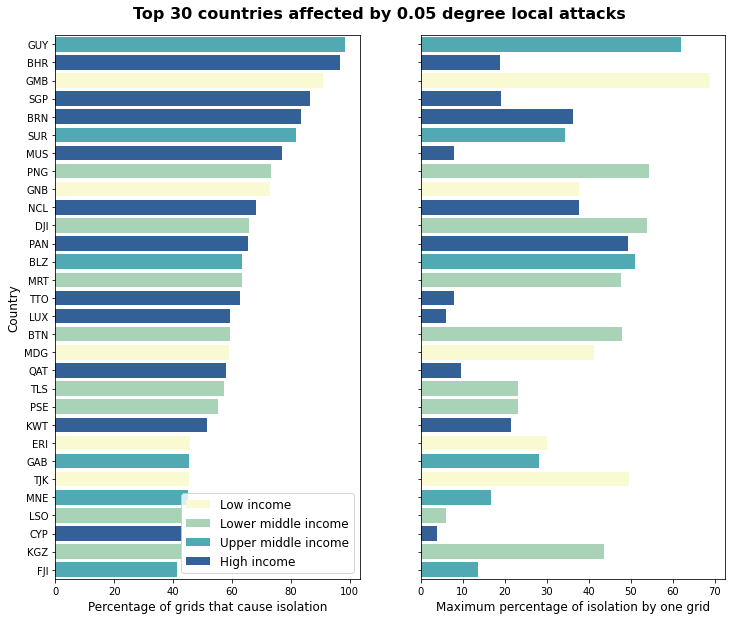

In [46]:
fig,axes = plt.subplots(1,2,figsize=(12,10),sharey=True) 

color_scheme = ['#41b6c4','#225ea8','#ffffcc','#a1dab4'] #,"fe6d73"]

for iter_,ax in enumerate(axes.flatten()):

    if iter_ == 0:
        sns.set_palette(sns.color_palette(color_scheme))

        data = local_results_005.loc[local_results_005.Total_Edge_Length > 1e6].sort_values('pct_grids_cause_isolation_005',ascending=False)[:30]
        sns.barplot(x=data.pct_grids_cause_isolation_005, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Percentage of grids that cause isolation',fontsize=12)
        ax.set_ylabel('Country',fontsize=12)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[2],handles[3],handles[0],handles[1]]
        labels = [labels[2],labels[3],labels[0],labels[1]]
        ax.legend(handles, labels, loc='lower right',prop={'size': 12})
        
    else:
        sns.set_palette(sns.color_palette(color_scheme))

        data = local_results_005.loc[local_results_005.Total_Edge_Length > 1e6].sort_values('pct_grids_cause_isolation_005',ascending=False)[:30]
        sns.barplot(x=data.max_pct_trips_isolated_005, y=data.index, data=data,hue=data.IncomeLevel,dodge=False,ax=ax)

        ax.set_xlabel('Maximum percentage of isolation by one grid',fontsize=12)

        #handles, labels = ax.get_legend_handles_labels()
        #handles = [handles[1],handles[0],handles[2],handles[3]]
        #labels = [labels[1],labels[0],labels[2],labels[3]]
        #ax.legend(handles, labels, loc='lower right',prop={'size': 12})
        ax.legend([],[], frameon=False)
        
    plt.suptitle("Top 30 countries affected by 0.05 degree local attacks",fontsize=16,y=0.92,fontweight='bold')      

plt.savefig('top30_localattack005.png',dpi=500,facecolor='white', bbox_inches='tight')
    

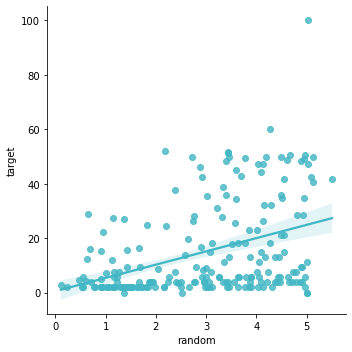

In [47]:
tar_vs_random = pd.DataFrame([target_results.max_pct_trips_isolated,random_mean_isolated.mean_gradient_0_20]).T.dropna()
tar_vs_random.columns = ['target','random']
sns.lmplot(x='random',y='target',data=tar_vs_random,fit_reg=True) 

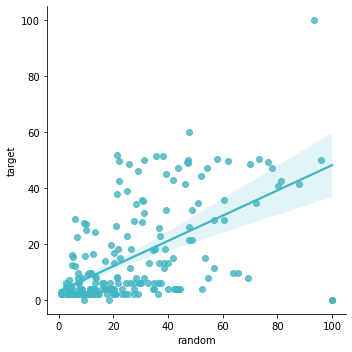

In [48]:
tar_vs_random = pd.DataFrame([target_results.max_pct_trips_isolated,random_mean_isolated[10]]).T.dropna()
tar_vs_random.columns = ['target','random']
sns.lmplot(x='random',y='target',data=tar_vs_random,fit_reg=True) 

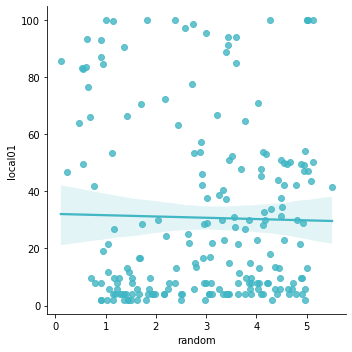

In [49]:
loc_vs_random = pd.DataFrame([local_results_01.max_pct_trips_isolated_01,random_mean_isolated.mean_gradient_0_20]).T.dropna()
loc_vs_random.columns = ['local01','random']
sns.lmplot(x='random',y='local01',data=loc_vs_random,fit_reg=True) 

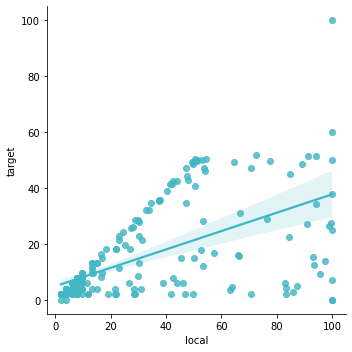

In [50]:
loc_vs_tar = pd.DataFrame([local_results_01.max_pct_trips_isolated_01,target_results.max_pct_trips_isolated]).T.dropna()
loc_vs_tar.columns = ['local','target']
sns.lmplot(x='local',y='target',data=loc_vs_tar,fit_reg=True) 

In [51]:
gadm36_to_plot = gadm36.merge(pd.DataFrame([local_results_05.max_pct_trips_isolated_05,local_results_01.max_pct_trips_isolated_01,
                                            local_results_005.max_pct_trips_isolated_005,target_results.max_pct_trips_isolated,random_mean_isolated.mean_gradient_0_20]).T,
             left_on='GID_0',right_index=True)

In [52]:
## collect all

df_results = pd.concat([local_results_05.max_pct_trips_isolated_05,local_results_05.pct_grids_cause_isolation_05,
          local_results_01.max_pct_trips_isolated_01,local_results_01.pct_grids_cause_isolation_01,
          local_results_005.max_pct_trips_isolated_005,local_results_005.pct_grids_cause_isolation_005,
            target_results.max_pct_trips_isolated,target_results.pct_edges_cause_isolation,
            random_mean_isolated.mean_gradient_0_20
          ],axis=1)

In [53]:
df_results['loc05'] = ((df_results.max_pct_trips_isolated_05/df_results.max_pct_trips_isolated_05.max())+
                        (df_results.pct_grids_cause_isolation_05/df_results.pct_grids_cause_isolation_05.max()))/2

df_results['loc01'] = ((df_results.max_pct_trips_isolated_01/df_results.max_pct_trips_isolated_01.max())+
                        (df_results.pct_grids_cause_isolation_01/df_results.pct_grids_cause_isolation_01.max()))/2

df_results['loc005'] = ((df_results.max_pct_trips_isolated_005/df_results.max_pct_trips_isolated_005.max())+
                        (df_results.pct_grids_cause_isolation_005/df_results.pct_grids_cause_isolation_005.max()))/2

df_results['target'] = ((df_results.max_pct_trips_isolated/df_results.max_pct_trips_isolated.max())+
                        (df_results.pct_edges_cause_isolation/df_results.pct_edges_cause_isolation.max()))/2

df_results['random'] = df_results.mean_gradient_0_20/df_results.mean_gradient_0_20.max()

df_results['avg_index'] =  (df_results.loc05+df_results.loc01+df_results.loc005+df_results.target+df_results.random)/5
df_results['ranked'] = df_results.avg_index.rank()

In [54]:
gadm36_to_plot = gadm36.merge(df_results,
             left_on='GID_0',right_index=True)

In [55]:
ranking = gadm36_to_plot[['NAME_0','loc05','loc01','loc005','target','random','avg_index','ranked']]

In [57]:
ranking.to_csv('ranked_all.csv')

<AxesSubplot:>

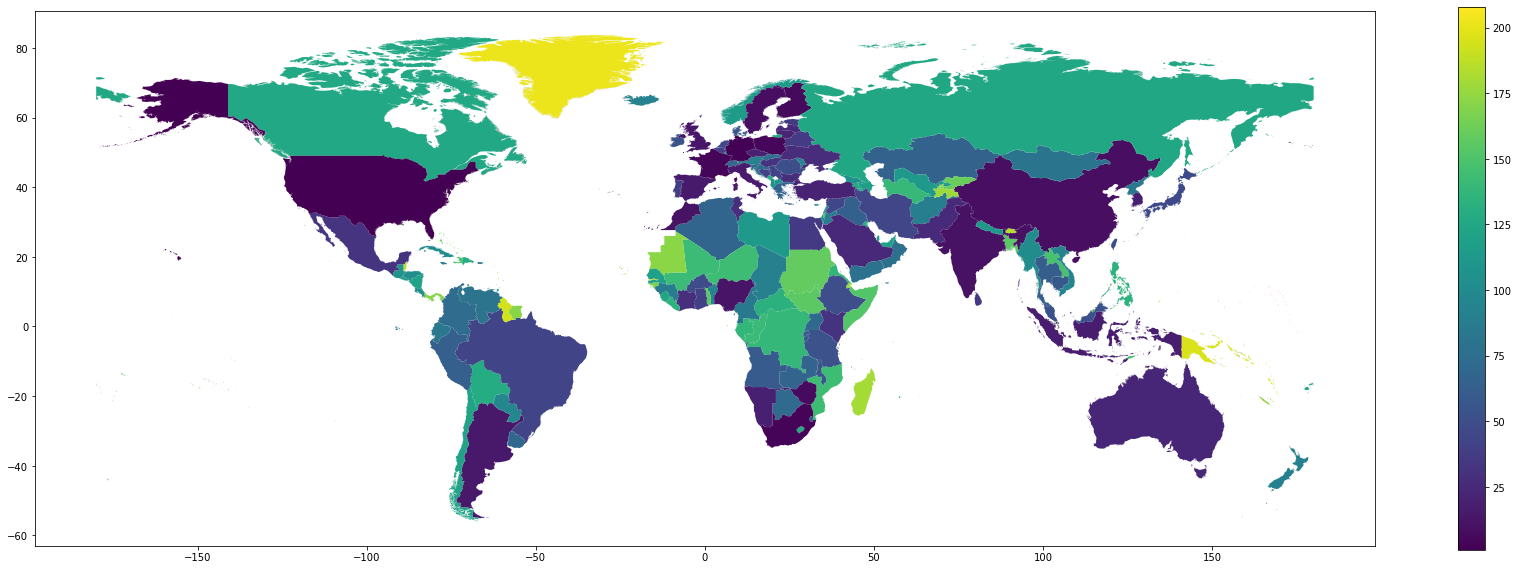

In [58]:
fig,ax = plt.subplots(1,1,figsize=(30,20))

gadm36_to_plot.plot(column='ranked',ax=ax,legend=True,legend_kwds={'shrink': 0.5})

In [59]:
gadm36_to_plot['loc05_norm'] = gadm36_to_plot.max_pct_trips_isolated_05/gadm36_to_plot.max_pct_trips_isolated_05.max()
gadm36_to_plot['loc01_norm'] = gadm36_to_plot.max_pct_trips_isolated_01/gadm36_to_plot.max_pct_trips_isolated_01.max()
gadm36_to_plot['loc005_norm'] = gadm36_to_plot.max_pct_trips_isolated_005/gadm36_to_plot.max_pct_trips_isolated_005.max()
gadm36_to_plot['tar_norm'] = gadm36_to_plot.max_pct_trips_isolated/gadm36_to_plot.max_pct_trips_isolated.max()
gadm36_to_plot['random_norm'] = gadm36_to_plot.mean_gradient_0_20/gadm36_to_plot.mean_gradient_0_20.max()

<AxesSubplot:>

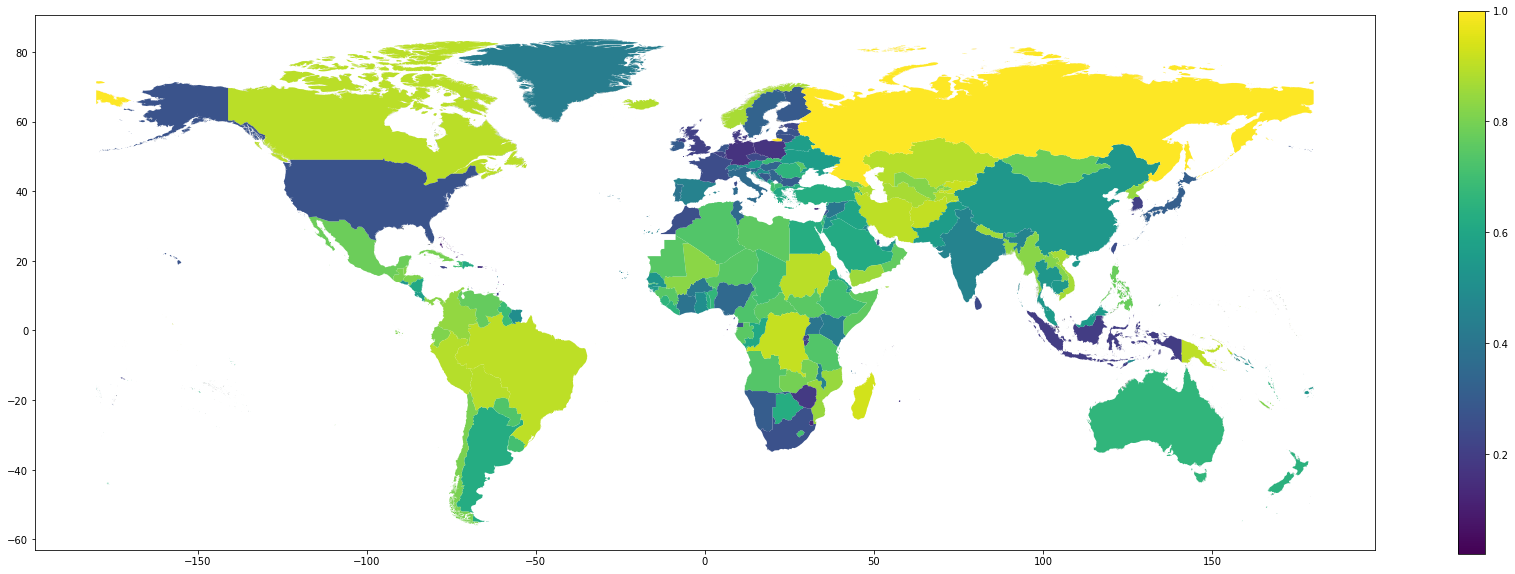

In [60]:
fig,ax = plt.subplots(1,1,figsize=(30,20))

gadm36_to_plot.plot(column='random_norm',ax=ax,legend=True,legend_kwds={'shrink': 0.5})

<AxesSubplot:>

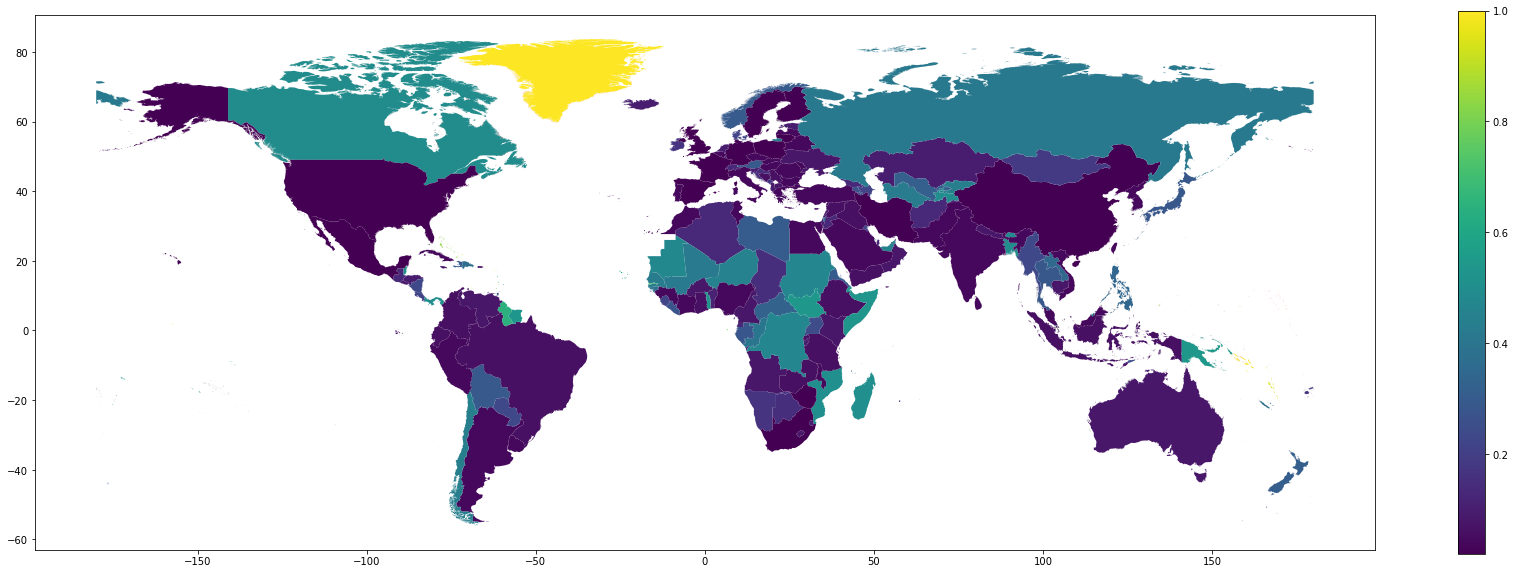

In [61]:
fig,ax = plt.subplots(1,1,figsize=(30,20))

gadm36_to_plot.plot(column='loc01_norm',ax=ax,legend=True,legend_kwds={'shrink': 0.5})

<AxesSubplot:>

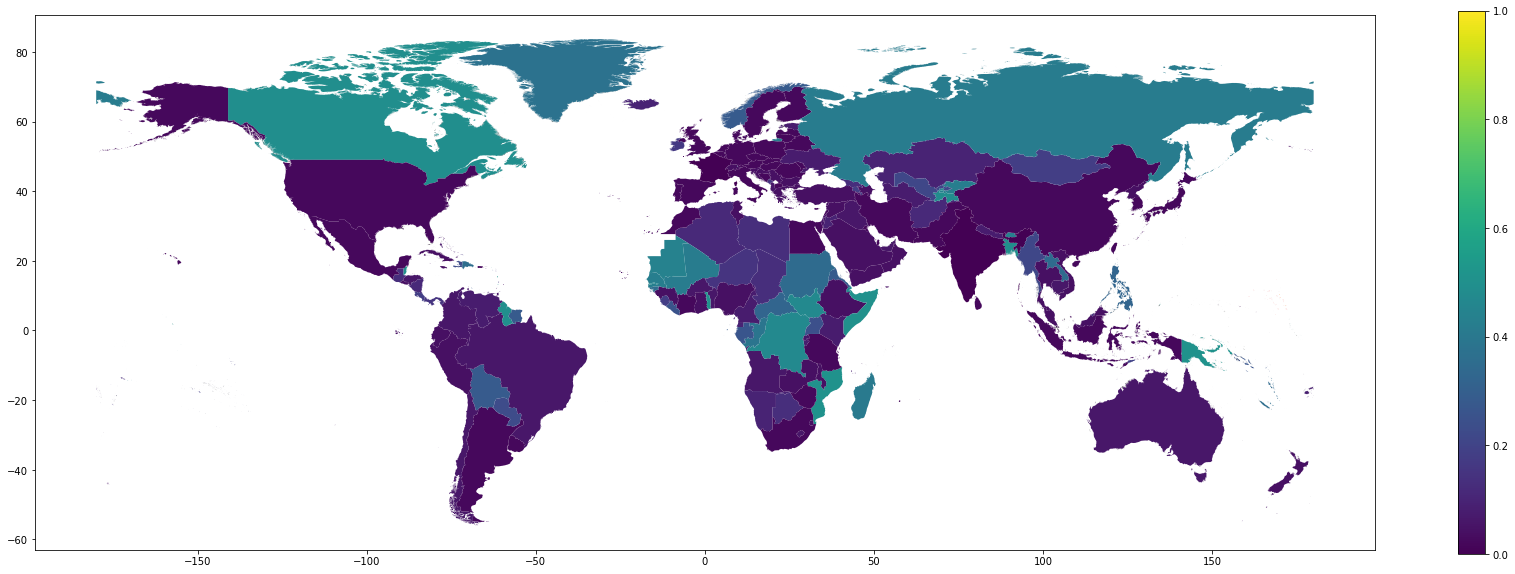

In [62]:
fig,ax = plt.subplots(1,1,figsize=(30,20))

gadm36_to_plot.plot(column='tar_norm',ax=ax,legend=True,legend_kwds={'shrink': 0.5})

In [63]:
gadm36_to_plot['perc_indicator'] = ((gadm36_to_plot.loc05_norm +gadm36_to_plot.loc01_norm + gadm36_to_plot.loc005_norm)/3 +  gadm36_to_plot.random_norm + gadm36_to_plot.tar_norm)/3

<AxesSubplot:>

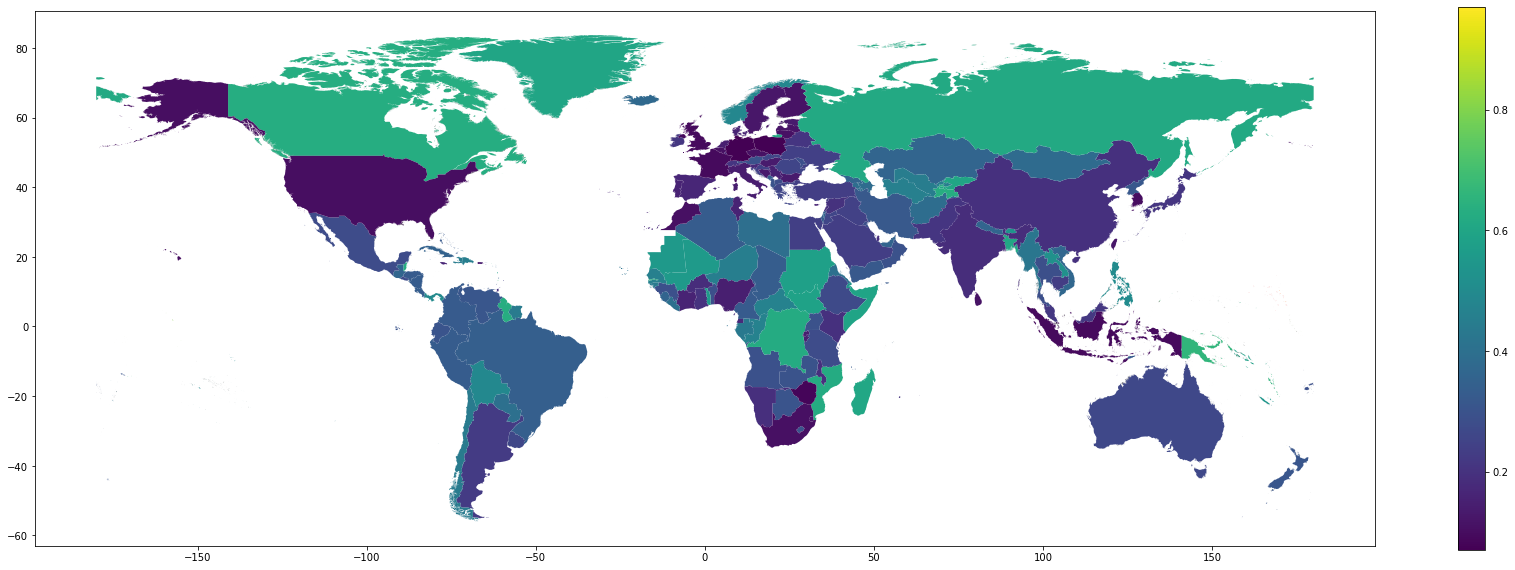

In [64]:
fig,ax = plt.subplots(1,1,figsize=(30,20))

gadm36_to_plot.plot(column='perc_indicator',ax=ax,legend=True,legend_kwds={'shrink': 0.5})

In [65]:
ranking = gadm36_to_plot[['NAME_0','loc05_norm','loc01_norm','loc005_norm','tar_norm', 'random_norm', 'perc_indicator']]
ranking[['loc05_norm','loc01_norm','loc005_norm','tar_norm', 'random_norm', 'perc_indicator']] = ranking[['loc05_norm','loc01_norm','loc005_norm','tar_norm', 'random_norm', 'perc_indicator']].rank()

In [66]:
ranking.sort_values('perc_indicator').head(30)

NAME_0  loc05_norm  loc01_norm  loc005_norm  tar_norm  \
59                  Germany         6.5         7.5         10.5      30.5   
179                  Poland        17.5         7.5         10.5      30.5   
255                Zimbabwe        29.5         7.5         10.5      30.5   
102               Indonesia        29.5        49.0         55.0      30.5   
75                   France        13.5         7.5         10.5       2.5   
79           United Kingdom        47.5         7.5         10.5      30.5   
122             South Korea        51.5        31.5         22.0      30.5   
234           United States         1.0         7.5         10.5      30.5   
18                  Belgium        67.0        31.5         38.5      30.5   
137                 Morocco        17.5        31.5         38.5      30.5   
253            South Africa        22.5         7.5         10.5      30.5   
58           Czech Republic        51.5        31.5         38.5      30.5   
132               Lithuania        51.5         7.5         10.5      30.5   
130               Sri Lanka        71.5        31.5         10.5      30.5   
72                  Finland         6.5         7.5         10.5      30.5   
134                  Latvia        29.5        31.5         38.5      30.5   
211               Swaziland       112.0        87.5         82.0      73.5   
228                  Taiwan        79.0        31.5         38.5      30.5   
210                  Sweden         6.5         7.5         10.5      30.5   
26   Bosnia and Herzegovina        60.0        59.5         38.5      30.5   
23                 Bulgaria        45.0        31.5         38.5      73.5   
101                 Hungary        29.5        31.5         10.5      30.5   
70                  Estonia        51.5        83.0         82.0     114.5   
180             Puerto Rico       149.0        76.0         38.5      30.5   
111                   Italy        13.5        31.5         38.5      30.5   
190                  Rwanda       101.0        59.5         64.5     100.5   
166             Netherlands        78.0        83.0         89.0      30.5   
163                 Nigeria        13.5        31.5         38.5      73.5   
17                  Burundi        95.0        83.0         92.5     114.5   
204                  Serbia        56.0        59.5         64.5      73.5   

     random_norm  perc_indicator  
59          15.0             1.0  
179         17.0             2.0  
255         22.0             3.0  
102         25.0             4.0  
75          38.0             5.0  
79          28.5             6.0  
122         28.5             7.0  
234         47.0             8.0  
18          32.0             9.0  
137         41.0            10.0  
253         44.0            11.0  
58          37.0            12.0  
132         45.0            13.0  
130         36.0            14.0  
72          52.0            15.0  
134         49.0            16.0  
211         11.0            17.0  
228         39.0            18.0  
210         58.0            19.0  
26          51.0            20.0  
23          53.0            21.0  
101         60.0            22.0  
70          35.0            23.0  
180         14.0            24.0  
111         65.0            25.0  
190         34.0            26.0  
166         50.0            27.0  
163         64.0            28.0  
17          31.0            29.0  
204         61.0            30.0

In [67]:
ranking.sort_values('perc_indicator').head(30)

NAME_0  loc05_norm  loc01_norm  loc005_norm  tar_norm  \
59                  Germany         6.5         7.5         10.5      30.5   
179                  Poland        17.5         7.5         10.5      30.5   
255                Zimbabwe        29.5         7.5         10.5      30.5   
102               Indonesia        29.5        49.0         55.0      30.5   
75                   France        13.5         7.5         10.5       2.5   
79           United Kingdom        47.5         7.5         10.5      30.5   
122             South Korea        51.5        31.5         22.0      30.5   
234           United States         1.0         7.5         10.5      30.5   
18                  Belgium        67.0        31.5         38.5      30.5   
137                 Morocco        17.5        31.5         38.5      30.5   
253            South Africa        22.5         7.5         10.5      30.5   
58           Czech Republic        51.5        31.5         38.5      30.5   
132               Lithuania        51.5         7.5         10.5      30.5   
130               Sri Lanka        71.5        31.5         10.5      30.5   
72                  Finland         6.5         7.5         10.5      30.5   
134                  Latvia        29.5        31.5         38.5      30.5   
211               Swaziland       112.0        87.5         82.0      73.5   
228                  Taiwan        79.0        31.5         38.5      30.5   
210                  Sweden         6.5         7.5         10.5      30.5   
26   Bosnia and Herzegovina        60.0        59.5         38.5      30.5   
23                 Bulgaria        45.0        31.5         38.5      73.5   
101                 Hungary        29.5        31.5         10.5      30.5   
70                  Estonia        51.5        83.0         82.0     114.5   
180             Puerto Rico       149.0        76.0         38.5      30.5   
111                   Italy        13.5        31.5         38.5      30.5   
190                  Rwanda       101.0        59.5         64.5     100.5   
166             Netherlands        78.0        83.0         89.0      30.5   
163                 Nigeria        13.5        31.5         38.5      73.5   
17                  Burundi        95.0        83.0         92.5     114.5   
204                  Serbia        56.0        59.5         64.5      73.5   

     random_norm  perc_indicator  
59          15.0             1.0  
179         17.0             2.0  
255         22.0             3.0  
102         25.0             4.0  
75          38.0             5.0  
79          28.5             6.0  
122         28.5             7.0  
234         47.0             8.0  
18          32.0             9.0  
137         41.0            10.0  
253         44.0            11.0  
58          37.0            12.0  
132         45.0            13.0  
130         36.0            14.0  
72          52.0            15.0  
134         49.0            16.0  
211         11.0            17.0  
228         39.0            18.0  
210         58.0            19.0  
26          51.0            20.0  
23          53.0            21.0  
101         60.0            22.0  
70          35.0            23.0  
180         14.0            24.0  
111         65.0            25.0  
190         34.0            26.0  
166         50.0            27.0  
163         64.0            28.0  
17          31.0            29.0  
204         61.0            30.0